Copyright 2021 DeepMind Technologies Limited

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

This colab showcases the usage of the Enformer model published in

**"Effective gene expression prediction from sequence by integrating long-range interactions"**

Žiga Avsec, Vikram Agarwal, Daniel Visentin, Joseph R. Ledsam, Agnieszka Grabska-Barwinska, Kyle R. Taylor, Yannis Assael, John Jumper, Pushmeet Kohli, David R. Kelley

**Note:** This colab will not yet work since the model isn't yet publicly available. We are working on enabling this and will update the colab accordingly.

### Steps

This colab demonstrates how to
- Make predictions with Enformer and reproduce Fig. 1d
- Compute contribution scores and reproduce parts of Fig. 2a
- Predict the effect of a genetic variant and reproduce parts of Fig. 3g
- Score multiple variants in a VCF

## Setup

**Start the colab kernel with GPU**: Runtime -> Change runtime type -> GPU

In [38]:
import tensorflow as tf
# Make sure the GPU is enabled
assert tf.config.list_physical_devices('GPU'), 'Start the colab kernel with GPU: Runtime -> Change runtime type -> GPU'

In [39]:
!pip install kipoiseq==0.5.2 --quiet > /dev/null
# You can ignore the pyYAML error

### Imports

In [40]:
import tensorflow_hub as hub
import joblib
import gzip
import kipoiseq
from kipoiseq import Interval
import pyfaidx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [41]:
transform_path = 'gs://dm-enformer/models/enformer.finetuned.SAD.robustscaler-PCA500-robustscaler.transform.pkl'
model_path = 'https://tfhub.dev/deepmind/enformer/1'
fasta_file = '/root/data/genome.fa'
clinvar_vcf = '/root/data/clinvar.vcf.gz'

In [42]:
# Download targets from Basenji2 dataset
# Cite: Kelley et al Cross-species regulatory sequence activity prediction. PLoS Comput. Biol. 16, e1008050 (2020).
targets_txt = 'https://raw.githubusercontent.com/calico/basenji/master/manuscripts/cross2020/targets_human.txt'
df_targets = pd.read_csv(targets_txt, sep='\t')
df_targets.head(3)

,index,genome,identifier,file,clip,scale,sum_stat,description
0,0,0,ENCFF833POA,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:cerebellum male adult (27 years) and mal...
1,1,0,ENCFF110QGM,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:frontal cortex male adult (27 years) and...
2,2,0,ENCFF880MKD,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:chorion


### Download files

Download and index the reference genome fasta file

Credit to Genome Reference Consortium: https://www.ncbi.nlm.nih.gov/grc

Schneider et al 2017 http://dx.doi.org/10.1101/gr.213611.116: Evaluation of GRCh38 and de novo haploid genome assemblies demonstrates the enduring quality of the reference assembly

In [43]:
!mkdir -p /root/data
!wget -O - http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gunzip -c > {fasta_file}
pyfaidx.Faidx(fasta_file)
!ls /root/data

--2025-11-09 15:07:48--  http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 983659424 (938M) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>] 938.09M  17.0MB/s    in 59s     

2025-11-09 15:08:48 (15.8 MB/s) - written to stdout [983659424/983659424]

clinvar.vcf.gz	genome.fa  genome.fa.fai


Download the clinvar file. Reference:

Landrum MJ, Lee JM, Benson M, Brown GR, Chao C, Chitipiralla S, Gu B, Hart J, Hoffman D, Jang W, Karapetyan K, Katz K, Liu C, Maddipatla Z, Malheiro A, McDaniel K, Ovetsky M, Riley G, Zhou G, Holmes JB, Kattman BL, Maglott DR. ClinVar: improving access to variant interpretations and supporting evidence. Nucleic Acids Res . 2018 Jan 4. PubMed PMID: 29165669 .


In [44]:
!wget https://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/clinvar.vcf.gz -O /root/data/clinvar.vcf.gz

--2025-11-09 15:09:16--  https://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/clinvar.vcf.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.13, 130.14.250.7, 130.14.250.10, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 181263832 (173M) [application/x-gzip]
Saving to: ‘/root/data/clinvar.vcf.gz’

/root/data/clinvar. 100%[===================>] 172.87M  11.7MB/s    in 16s     

2025-11-09 15:09:34 (10.5 MB/s) - ‘/root/data/clinvar.vcf.gz’ saved [181263832/181263832]



### Code (double click on the title to show the code)

In [45]:
# @title `Enformer`, `EnformerScoreVariantsNormalized`, `EnformerScoreVariantsPCANormalized`,
SEQUENCE_LENGTH = 393216

class Enformer:

  def __init__(self, tfhub_url):
    self._model = hub.load(tfhub_url).model

  def predict_on_batch(self, inputs):
    predictions = self._model.predict_on_batch(inputs)
    return {k: v.numpy() for k, v in predictions.items()}

  @tf.function
  def contribution_input_grad(self, input_sequence,
                              target_mask, output_head='human'):
    input_sequence = input_sequence[tf.newaxis]

    target_mask_mass = tf.reduce_sum(target_mask)
    with tf.GradientTape() as tape:
      tape.watch(input_sequence)
      prediction = tf.reduce_sum(
          target_mask[tf.newaxis] *
          self._model.predict_on_batch(input_sequence)[output_head]) / target_mask_mass

    input_grad = tape.gradient(prediction, input_sequence) * input_sequence
    input_grad = tf.squeeze(input_grad, axis=0)
    return tf.reduce_sum(input_grad, axis=-1)


class EnformerScoreVariantsRaw:

  def __init__(self, tfhub_url, organism='human'):
    self._model = Enformer(tfhub_url)
    self._organism = organism

  def predict_on_batch(self, inputs):
    ref_prediction = self._model.predict_on_batch(inputs['ref'])[self._organism]
    alt_prediction = self._model.predict_on_batch(inputs['alt'])[self._organism]

    return alt_prediction.mean(axis=1) - ref_prediction.mean(axis=1)


class EnformerScoreVariantsNormalized:

  def __init__(self, tfhub_url, transform_pkl_path,
               organism='human'):
    assert organism == 'human', 'Transforms only compatible with organism=human'
    self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
    with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
      transform_pipeline = joblib.load(f)
    self._transform = transform_pipeline.steps[0][1]  # StandardScaler.

  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)


class EnformerScoreVariantsPCANormalized:

  def __init__(self, tfhub_url, transform_pkl_path,
               organism='human', num_top_features=500):
    self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
    with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
      self._transform = joblib.load(f)
    self._num_top_features = num_top_features

  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)[:, :self._num_top_features]


# TODO(avsec): Add feature description: Either PCX, or full names.

In [46]:
# @title `variant_centered_sequences`

class FastaStringExtractor:

    def __init__(self, fasta_file):
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}

    def extract(self, interval: Interval, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                          trimmed_interval.start + 1,
                                          trimmed_interval.stop).seq).upper()
        # Fill truncated values with N's.
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream

    def close(self):
        return self.fasta.close()


def variant_generator(vcf_file, gzipped=False):
  """Yields a kipoiseq.dataclasses.Variant for each row in VCF file."""
  def _open(file):
    return gzip.open(vcf_file, 'rt') if gzipped else open(vcf_file)

  with _open(vcf_file) as f:
    for line in f:
      if line.startswith('#'):
        continue
      chrom, pos, id, ref, alt_list = line.split('\t')[:5]
      # Split ALT alleles and return individual variants as output.
      for alt in alt_list.split(','):
        yield kipoiseq.dataclasses.Variant(chrom=chrom, pos=pos,
                                           ref=ref, alt=alt, id=id)


def one_hot_encode(sequence):
  return kipoiseq.transforms.functional.one_hot_dna(sequence).astype(np.float32)


def variant_centered_sequences(vcf_file, sequence_length, gzipped=False,
                               chr_prefix=''):
  seq_extractor = kipoiseq.extractors.VariantSeqExtractor(
    reference_sequence=FastaStringExtractor(fasta_file))

  for variant in variant_generator(vcf_file, gzipped=gzipped):
    interval = Interval(chr_prefix + variant.chrom,
                        variant.pos, variant.pos)
    interval = interval.resize(sequence_length)
    center = interval.center() - interval.start

    reference = seq_extractor.extract(interval, [], anchor=center)
    alternate = seq_extractor.extract(interval, [variant], anchor=center)

    yield {'inputs': {'ref': one_hot_encode(reference),
                      'alt': one_hot_encode(alternate)},
           'metadata': {'chrom': chr_prefix + variant.chrom,
                        'pos': variant.pos,
                        'id': variant.id,
                        'ref': variant.ref,
                        'alt': variant.alt}}

In [47]:
# @title `plot_tracks`

def plot_tracks(tracks, interval, height=1.5):
  fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(str(interval))
  plt.tight_layout()

## Make predictions for a genetic sequenece

In [48]:
model = Enformer(model_path)

fasta_extractor = FastaStringExtractor(fasta_file)

In [49]:
# === Enformer 分析 (rs77684561) 与数据导出模块 ===
# 此模块将运行预测、提取您关心的轨道、并将结果保存为 CSV 文件以便本地绘图

import pandas as pd
import numpy as np
from google.colab import files # 用于下载

print("--- 正在准备运行 SNP (rs77684561) 分析... ---")

# 1. 定义SNP信息 (使用 hg38 坐标: 111,623,918)
variant = kipoiseq.Variant('chr12', 111623918, 'C', 'T', id='rs77684561')

# 2. 运行核心预测 (与官方逻辑一致)
# 定义 SEQUENCE_LENGTH
try:
    SEQUENCE_LENGTH
except NameError:
    SEQUENCE_LENGTH = 393216

interval = kipoiseq.Interval(variant.chrom, variant.start, variant.start).resize(SEQUENCE_LENGTH)
seq_extractor = kipoiseq.extractors.VariantSeqExtractor(reference_sequence=fasta_extractor)
center = interval.center() - interval.start

reference = seq_extractor.extract(interval, [], anchor=center)
alternate = seq_extractor.extract(interval, [variant], anchor=center)

print("--- 正在对 REF 和 ALT 序列进行预测... ---")
reference_prediction = model.predict_on_batch(one_hot_encode(reference)[np.newaxis])['human'][0]
alternate_prediction = model.predict_on_batch(one_hot_encode(alternate)[np.newaxis])['human'][0]
print("--- 预测完成。正在处理数据以供导出... ---")

# 3. 定义我们关心的轨道索引 (来自您之前的代码)
idx_dnase_coronary = 193   # DNase:coronary artery
idx_h3k27ac_coronary = 2821 # H3K27ac:coronary artery
idx_h3k27me3 = None        # 稍后动态查找

# 4. 动态查找 H3K27me3 轨道索引 (复用您的 V2 逻辑)
print("--- 正在动态搜索 H3K27me3 轨道... ---")
h3k27me3_track = df_targets[df_targets['description'].str.contains('H3K27me3', case=False) &
                          df_targets['description'].str.contains('artery|endothelial', case=False, regex=True)]

if h3k27me3_track.empty:
    print("未找到动脉相关的 H3K27me3 轨道，尝试寻找 K562...")
    h3k27me3_track = df_targets[df_targets['description'].str.contains('H3K27me3', case=False) &
                              df_targets['description'].str.contains('K562', case=False)]

if not h3k27me3_track.empty:
    idx_h3k27me3 = h3k27me3_track['index'].iloc[0]
    h3k27me3_desc = h3k27me3_track['description'].iloc[0]
    print(f"成功找到 H3K27me3 轨道 -> 索引: {idx_h3k27me3}, 描述: {h3k27me3_desc}")
else:
    print("警告：未能在 df_targets 中找到任何 H3K27me3 轨道。")

# 5. 生成坐标轴 (X-axis)
output_bins = reference_prediction.shape[0] # 896
bin_size = 128
output_length = output_bins * bin_size # 114,688

output_interval_start = interval.center() - (output_length // 2)
output_interval_end = interval.center() + (output_length // 2)
output_interval = kipoiseq.Interval(variant.chrom, output_interval_start, output_interval_end)

# 生成每个 bin 的中心坐标
bin_centers = np.arange(output_interval.start, output_interval.end, bin_size) + (bin_size / 2)
bin_chrom = np.array([output_interval.chrom] * len(bin_centers))

# 6. 计算差值 (Y-axis)
diff_dnase_coronary = alternate_prediction[:, idx_dnase_coronary] - reference_prediction[:, idx_dnase_coronary]
diff_h3k27ac_coronary = alternate_prediction[:, idx_h3k27ac_coronary] - reference_prediction[:, idx_h3k27ac_coronary]

# 7. 合并为 DataFrame
df_export = pd.DataFrame({
    'chromosome': bin_chrom,
    'bin_center': bin_centers,
    'diff_dnase_coronary_artery': diff_dnase_coronary,
    'diff_h3k27ac_coronary_artery': diff_h3k27ac_coronary
})

# 仅当找到 H3K27me3 时才添加该列
if idx_h3k27me3 is not None:
    diff_h3k27me3 = alternate_prediction[:, idx_h3k27me3] - reference_prediction[:, idx_h3k27me3]
    # 使用 .loc 避免 SettingWithCopyWarning
    df_export.loc[:, f'diff_h3k27me3_{h3k27me3_desc[:20]}'] = diff_h3k27me3

print("--- 数据已准备完毕，以下是前 5 行预览：---")
print(df_export.head())

# 8. 保存并下载 CSV 文件
output_filename = 'enformer_rs77684561_predictions.csv'
df_export.to_csv(output_filename, index=False)

print(f"\n--- 成功保存数据到 {output_filename} ---")
print("--- 正在为您启动下载... ---")
files.download(output_filename)

--- 正在准备运行 SNP (rs77684561) 分析... ---
--- 正在对 REF 和 ALT 序列进行预测... ---
--- 预测完成。正在处理数据以供导出... ---
--- 正在动态搜索 H3K27me3 轨道... ---
成功找到 H3K27me3 轨道 -> 索引: 694, 描述: CHIP:H3K27me3:endothelial cell of umbilical vein male newborn
--- 数据已准备完毕，以下是前 5 行预览：---
  chromosome   bin_center  diff_dnase_coronary_artery  \
0      chr12  111566637.0                    0.000003   
1      chr12  111566765.0                    0.000007   
2      chr12  111566893.0                    0.000010   
3      chr12  111567021.0                    0.000007   
4      chr12  111567149.0                    0.000012   

   diff_h3k27ac_coronary_artery  diff_h3k27me3_CHIP:H3K27me3:endoth  
0                     -0.000090                            0.000032  
1                     -0.000101                            0.000016  
2                     -0.000013                            0.000036  
3                     -0.000025                            0.000057  
4                     -0.000009                           

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--- 正在使用内存中的数据生成 H3K27ac vs H3K27me3 对比图... ---
成功添加 H3K27me3 轨道。


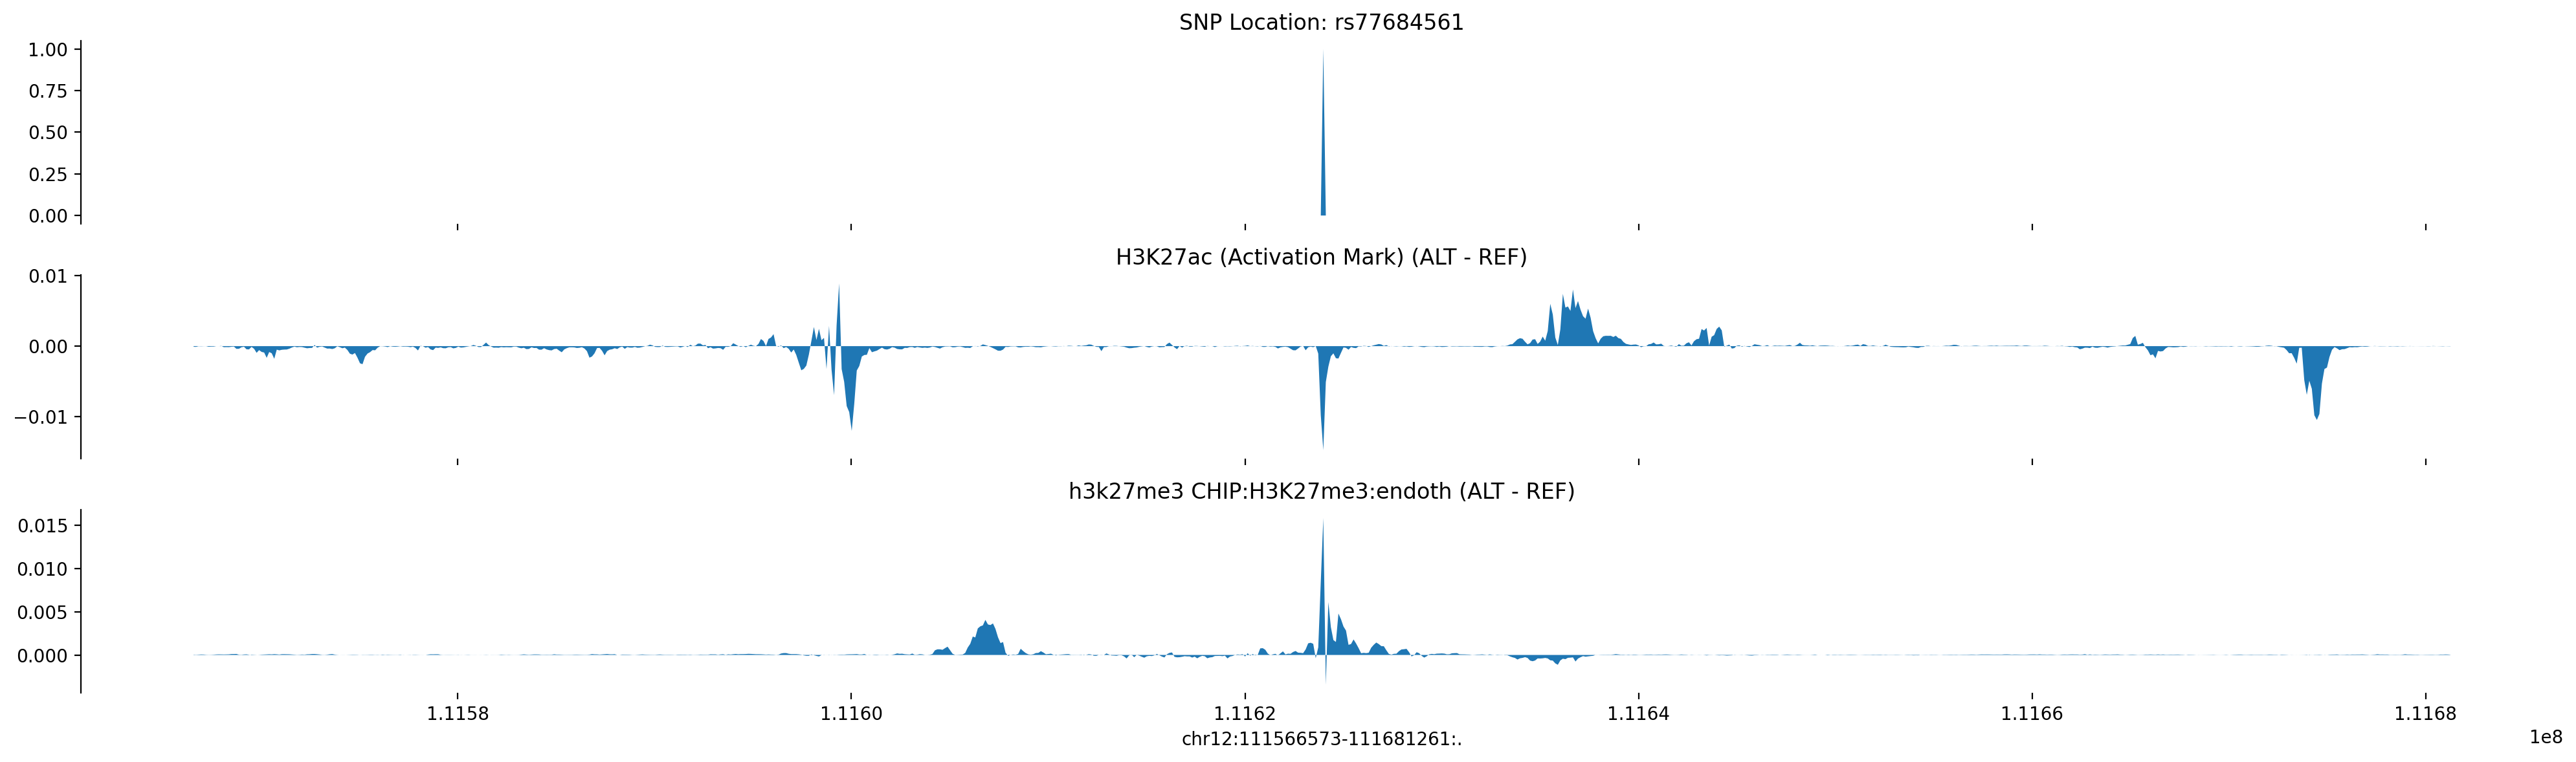

In [50]:
# === 绘图模块 ===
# (假设您刚刚已经运行了"数据导出模块")
# 此模块使用内存中已有的数据来重新绘制您上传的那张图

print("--- 正在使用内存中的数据生成 H3K27ac vs H3K27me3 对比图... ---")

# 1. 准备一个轨道来标记 SNP 的精确位置
variant_track = np.zeros_like(reference_prediction[:, 0], dtype=bool)
variant_track[variant_track.shape[0] // 2] = True # 在中心点标记

# 2. 准备绘图用的数据字典 (使用已计算好的差值)
# (这些 diff_... 变量都来自您刚运行的上一个单元格)
tracks_to_plot = {
    f'SNP Location: {variant.id}': variant_track,

    f'H3K27ac (Activation Mark) (ALT - REF)': diff_h3k27ac_coronary,
}

# 3. 检查 H3K27me3 数据是否存在并添加
# (idx_h3k27me3 和 diff_h3k27me3 变量也来自上一个单元格)
if idx_h3k27me3 is not None:
    # 动态获取 H3K27me3 的列名，以防万一
    h3k27me3_col_name = [col for col in df_export.columns if 'h3k27me3' in col]
    if h3k27me3_col_name:
        tracks_to_plot[f'{h3k27me3_col_name[0].replace("diff_","").replace("_"," ")} (ALT - REF)'] = df_export[h3k27me3_col_name[0]]
    else:
        # 备用方案，如果 df_export 意外没有该列
        diff_h3k27me3 = alternate_prediction[:, idx_h3k27me3] - reference_prediction[:, idx_h3k27me3]
        tracks_to_plot['H3K27me3 (Repressive Mark) (ALT - REF)'] = diff_h3k27me3

    print("成功添加 H3K27me3 轨道。")
else:
    print("警告: 内存中未找到 H3K27me3 数据，只绘制 H3K27ac。")

# 4. 调用 plot_tracks 函数进行绘图
# (plot_tracks 函数是您在 Part 1 中定义的)
plot_tracks(
    tracks_to_plot,
    interval.resize(reference_prediction.shape[0] * 128),
    height=2  # 您可以调整这个高度
)

In [51]:
# === 单元格 3: 与公共数据库 (GTEx eQTL & GWAS Catalog) 整合 ===
import requests
import json

print(f"--- 正在查询公共数据库中关于 {variant.id} ({variant.chrom}:{variant.pos}) 的信息... ---")

# 1. 定义查询函数
def query_gtex_eqtl(variant_id):
    """查询 GTEx Portal V8 API 获取 eQTL 信息"""
    print(f"\n--- 查询 GTEx eQTL 数据库 for {variant_id}... ---")
    server = "https://gtexportal.org/api/v2/association/singleVariant"
    params = {'variantId': variant_id, 'format': 'json'}

    try:
        r = requests.get(server, params=params)
        r.raise_for_status() # 如果请求失败 (如 404, 500), 会抛出异常
        results = r.json().get('singleVariantAssociation', [])

        if not results:
            print(f"在 GTEx V8 中未找到 {variant_id} 的显著 eQTL 记录。")
            return

        print(f"成功！为 {variant_id} 找到 {len(results)} 条 eQTL 记录:")
        df_eqtl = pd.DataFrame(results)
        # 展示关键信息
        display_cols = ['geneSymbol', 'tissueSiteDetailId', 'nes', 'pValue']
        print(df_eqtl[display_cols].sort_values('pValue').head(10))

    except requests.exceptions.RequestException as e:
        print(f"查询 GTEx 时出错: {e}")
    except json.JSONDecodeError:
        print("无法解析来自 GTEx 的响应。")

def query_gwas_catalog(variant_id):
    """查询 NHGRI-EBI GWAS Catalog 获取性状关联信息"""
    print(f"\n--- 查询 NHGRI-EBI GWAS Catalog for {variant_id}... ---")
    server = "https://www.ebi.ac.uk/gwas/rest/api/singleNucleotidePolymorphisms"
    url = f"{server}/{variant_id}/associations"
    headers = {"Content-Type": "application/json"}

    try:
        r = requests.get(url, headers=headers)
        r.raise_for_status()
        results = r.json().get('_embedded', {}).get('associations', [])

        if not results:
            print(f"在 GWAS Catalog 中未找到 {variant_id} 的关联记录。")
            return

        print(f"成功！为 {variant_id} 找到 {len(results)} 条 GWAS 关联记录:")

        association_list = []
        for assoc in results:
            trait_info = assoc.get('traitName', [{}])[0]
            association_list.append({
                'p_value': assoc.get('pValue'),
                'trait': trait_info.get('trait'),
                'risk_allele': assoc.get('riskAllele', [{}])[0].get('riskAlleleName', 'N/A')
            })

        df_gwas = pd.DataFrame(association_list)
        print(df_gwas.sort_values('p_value').head(10))

    except requests.exceptions.RequestException as e:
        print(f"查询 GWAS Catalog 时出错: {e}")
    except json.JSONDecodeError:
        print("无法解析来自 GWAS Catalog 的响应。")

# 2. 对您的SNP执行查询
query_gtex_eqtl(variant.id)
query_gwas_catalog(variant.id)

--- 正在查询公共数据库中关于 rs77684561 (chr12:111623918) 的信息... ---

--- 查询 GTEx eQTL 数据库 for rs77684561... ---
查询 GTEx 时出错: 404 Client Error: Not Found for url: https://gtexportal.org/api/v2/association/singleVariant?variantId=rs77684561&format=json

--- 查询 NHGRI-EBI GWAS Catalog for rs77684561... ---
成功！为 rs77684561 找到 2 条 GWAS 关联记录:
  p_value trait risk_allele
0    None  None         N/A
1    None  None         N/A


--- 准备针对您选择的细胞类型进行特异性分析 ---

--- 正在处理: 主动脉内皮细胞 ---
已计算 H3K27ac for Aortic Endothelial.
已计算 RUNX1 for Aortic Endothelial.

--- 正在处理: 平滑肌细胞 ---
已计算 H3K27ac for Smooth Muscle.

--- 正在生成 主动脉内皮细胞 的对比图... ---


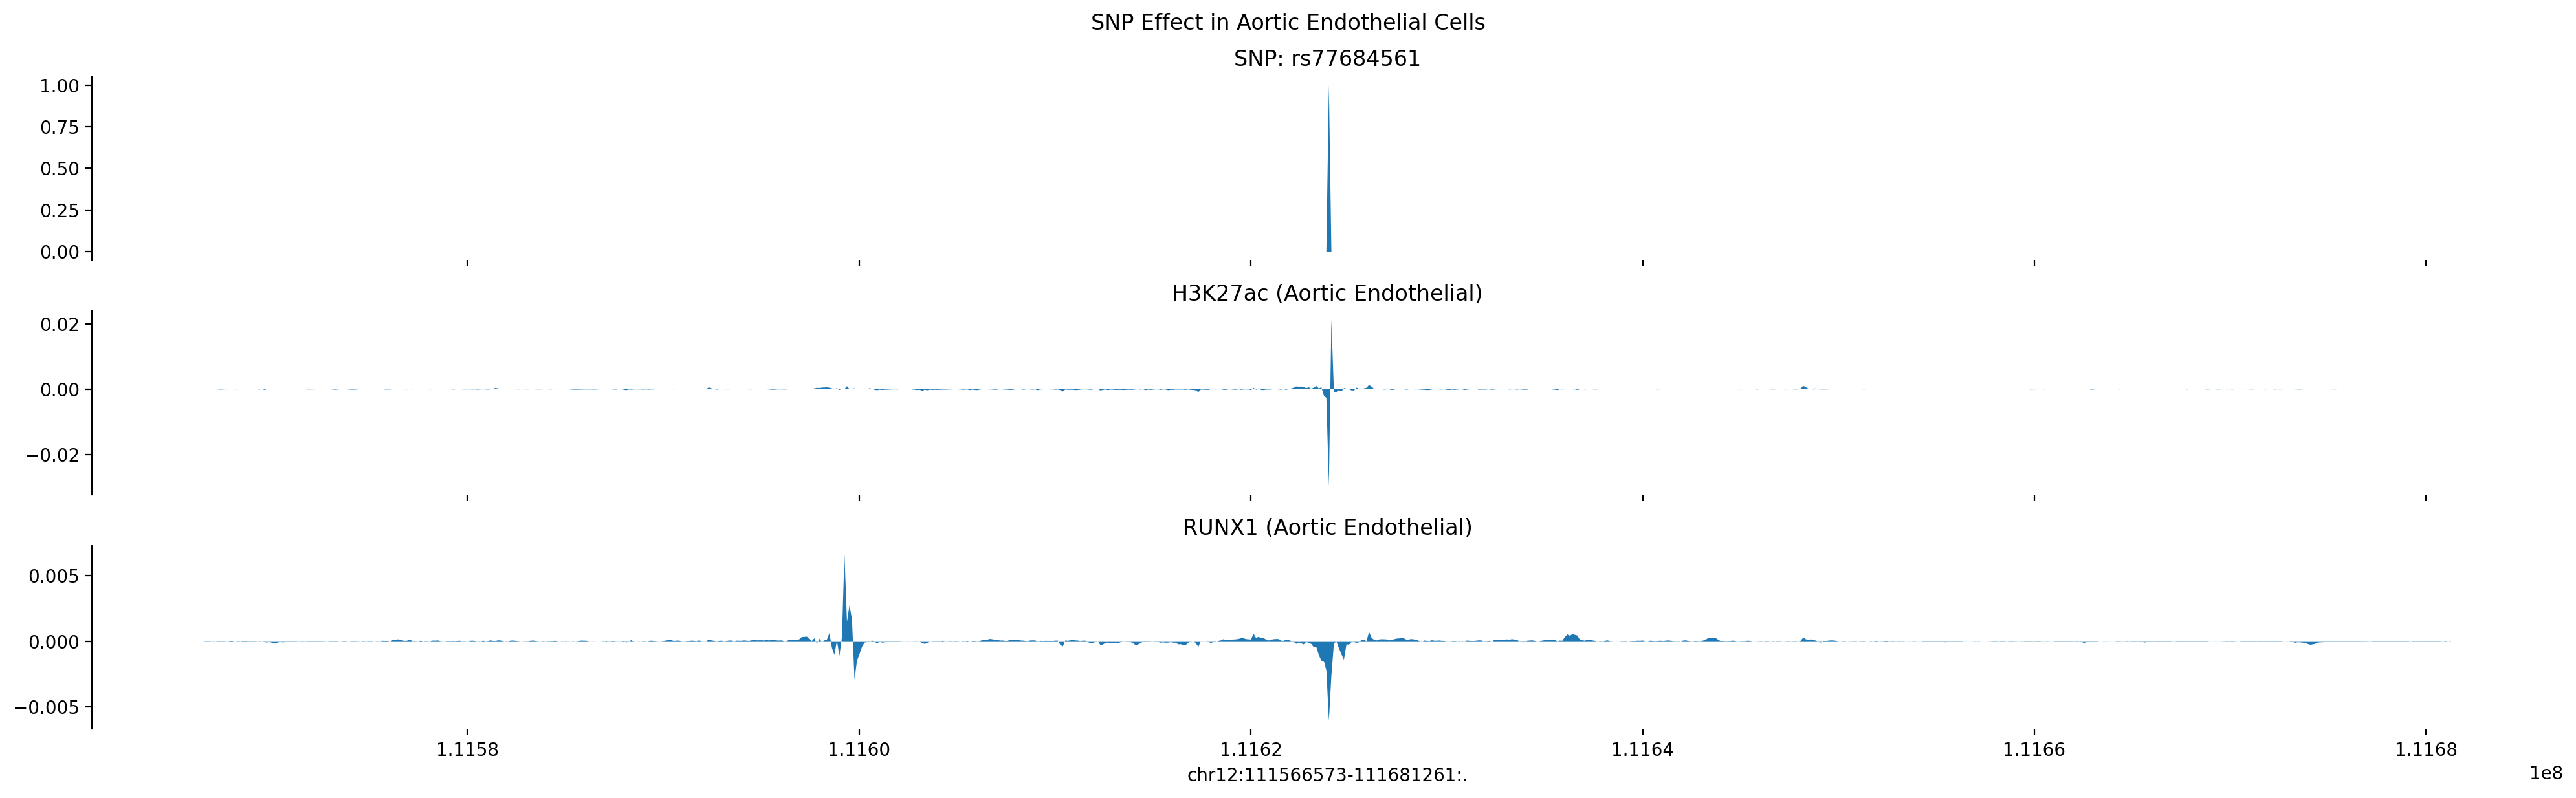


--- 正在生成 平滑肌细胞 的对比图... ---


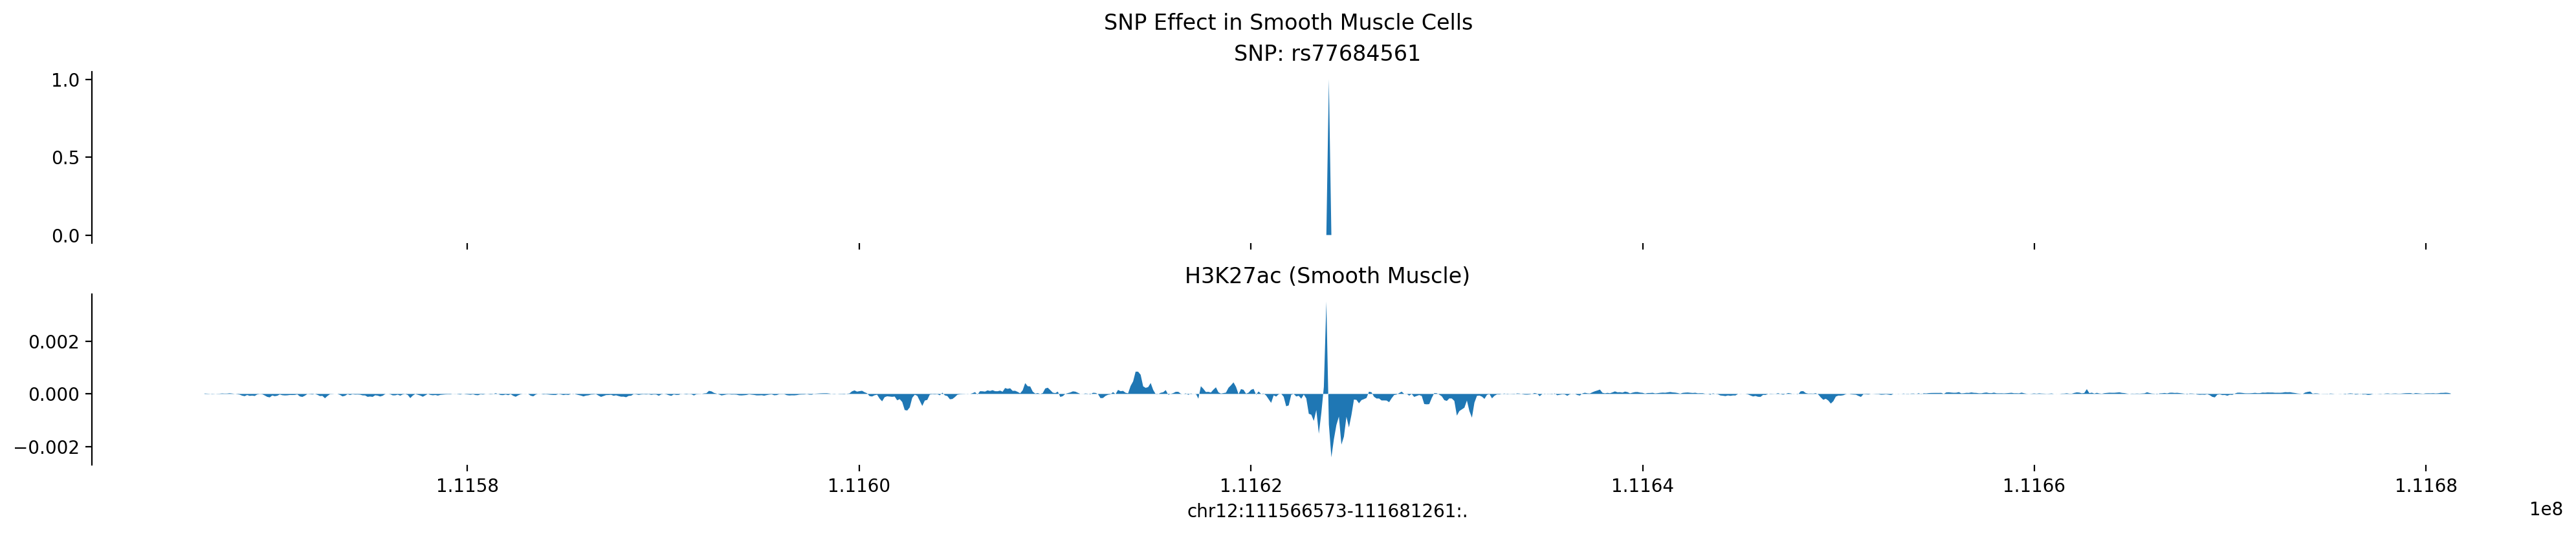

In [52]:
# === 单元格 2: 综合分析代码 - 主动脉内皮细胞和平滑肌细胞 ===

print("--- 准备针对您选择的细胞类型进行特异性分析 ---")

# --- 请根据上一步的输出，在此处修改轨道索引 ---
# 主动脉内皮细胞 (Aortic Endothelial Cells)
idx_h3k27ac_aorta = 2820  # CHIP:H3K27ac:aortic endothelial cell
idx_runx1_aorta = 2707    # CHIP:RUNX1:aortic endothelial cell (如果存在)

# 血管平滑肌细胞 (Vascular Smooth Muscle Cells)
# 注意: Enformer中可能没有主动脉平滑肌，但有其他来源的平滑肌细胞
idx_h3k27ac_smc = 3012  # CHIP:H3K27ac:pulmonary artery smooth muscle cell (示例)
idx_runx1_smc = None      # 可能不存在，设为None

# ----------------------------------------------------

# 创建两个独立的绘图字典，一个用于内皮细胞，一个用于平滑肌
tracks_aorta = {}
tracks_smc = {}

# --- 处理主动脉内皮细胞 ---
print("\n--- 正在处理: 主动脉内皮细胞 ---")
tracks_aorta[f'SNP: {variant.id}'] = variant_track # SNP位置标记

if idx_h3k27ac_aorta is not None:
    diff_h3k27ac_aorta = alternate_prediction[:, idx_h3k27ac_aorta] - reference_prediction[:, idx_h3k27ac_aorta]
    tracks_aorta['H3K27ac (Aortic Endothelial)'] = diff_h3k27ac_aorta
    print("已计算 H3K27ac for Aortic Endothelial.")

if idx_runx1_aorta is not None:
    diff_runx1_aorta = alternate_prediction[:, idx_runx1_aorta] - reference_prediction[:, idx_runx1_aorta]
    tracks_aorta['RUNX1 (Aortic Endothelial)'] = diff_runx1_aorta
    print("已计算 RUNX1 for Aortic Endothelial.")

# --- 处理平滑肌细胞 ---
print("\n--- 正在处理: 平滑肌细胞 ---")
tracks_smc[f'SNP: {variant.id}'] = variant_track

if idx_h3k27ac_smc is not None:
    diff_h3k27ac_smc = alternate_prediction[:, idx_h3k27ac_smc] - reference_prediction[:, idx_h3k27ac_smc]
    tracks_smc['H3K27ac (Smooth Muscle)'] = diff_h3k27ac_smc
    print("已计算 H3K27ac for Smooth Muscle.")

if idx_runx1_smc is not None:
    diff_runx1_smc = alternate_prediction[:, idx_runx1_smc] - reference_prediction[:, idx_runx1_smc]
    tracks_smc['RUNX1 (Smooth Muscle)'] = diff_runx1_smc
    print("已计算 RUNX1 for Smooth Muscle.")

# --- 可视化 ---
# 为主动脉内皮细胞绘图
if len(tracks_aorta) > 1:
    print("\n--- 正在生成 主动脉内皮细胞 的对比图... ---")
    plot_tracks(tracks_aorta,
                interval.resize(reference_prediction.shape[0] * 128),
                height=2)
    plt.suptitle("SNP Effect in Aortic Endothelial Cells", y=1.02) # 添加总标题
    plt.show() # 显示图像

# 为平滑肌细胞绘图
if len(tracks_smc) > 1:
    print("\n--- 正在生成 平滑肌细胞 的对比图... ---")
    plot_tracks(tracks_smc,
                interval.resize(reference_prediction.shape[0] * 128),
                height=2)
    plt.suptitle("SNP Effect in Smooth Muscle Cells", y=1.02)
    plt.show()

In [53]:
# 验证H3K27me3在平滑肌细胞中是否存在
df_targets[df_targets['description'].str.contains('H3K27me3', case=False) &
           df_targets['description'].str.contains('smooth muscle', case=False)]

,index,genome,identifier,file,clip,scale,sum_stat,description
1898,1898,0,ENCFF058CLL,/home/drk/tillage/datasets/human/chip/encode/E...,32,2,mean,CHIP:H3K27me3:smooth muscle cell originated fr...
2130,2130,0,ENCFF493JRG,/home/drk/tillage/datasets/human/chip/encode/E...,32,2,mean,CHIP:H3K27me3:stomach smooth muscle male adult...
2332,2332,0,ENCFF691LHZ,/home/drk/tillage/datasets/human/chip/encode/E...,32,2,mean,CHIP:H3K27me3:rectal smooth muscle tissue fema...
4342,4342,0,ENCFF459UPU,/home/drk/tillage/datasets/human/chip/encode/E...,32,2,mean,CHIP:H3K27me3:stomach smooth muscle female adu...


In [54]:
# === 数据导出模块: 保存所有细胞类型特异性差异数据 ===
import pandas as pd
from google.colab import files

print("--- 准备将所有计算的差异数据导出到单个CSV文件... ---")

# 1. 准备基础坐标信息 (X-axis)
#    (这些变量应已在您的环境中)
output_bins = reference_prediction.shape[0]
bin_size = 128
output_length = output_bins * bin_size
output_interval_start = interval.center() - (output_length // 2)
output_interval_end = interval.center() + (output_length // 2)
output_interval = kipoiseq.Interval(variant.chrom, output_interval_start, output_interval_end)
bin_centers = np.arange(output_interval.start, output_interval.end, bin_size) + (bin_size / 2)

# 2. 创建一个基础DataFrame
df_export_all = pd.DataFrame({
    'chromosome': output_interval.chrom,
    'bin_center': bin_centers
})

# 3. 逐一检查并添加已计算的差异数据
#    使用 locals().get() 来安全地检查变量是否存在

# K562 细胞数据 (来自您最初的分析)
if 'diff_h3k27ac_coronary' in locals(): # 用您之前的一个变量名代替
    idx_runx1_k562 = 2709
    diff_runx1_k562 = alternate_prediction[:, idx_runx1_k562] - reference_prediction[:, idx_runx1_k562]
    df_export_all['diff_h3k27ac_k562_like'] = diff_h3k27ac_coronary
    df_export_all['diff_runx1_k562'] = diff_runx1_k562

# 主动脉内皮细胞数据
if 'diff_h3k27ac_aorta' in locals():
    df_export_all['diff_h3k27ac_aortic_endothelial'] = diff_h3k27ac_aorta
if 'diff_runx1_aorta' in locals():
    df_export_all['diff_runx1_aortic_endothelial'] = diff_runx1_aorta

# 平滑肌细胞数据
if 'diff_h3k27ac_smc' in locals():
    df_export_all['diff_h3k27ac_smooth_muscle'] = diff_h3k27ac_smc

print("--- 数据已整合完毕，以下是预览：---")
print(df_export_all.head())

# 4. 保存到 CSV 并启动下载
output_filename = 'enformer_rs77684561_cell_specific_diffs.csv'
df_export_all.to_csv(output_filename, index=False)

print(f"\n--- 成功保存数据到 {output_filename} ---")
print("--- 正在为您启动下载... ---")
files.download(output_filename)

# 5. (可选) 如何在本地Python中重新加载和绘图的示例
print("\n--- 本地Python使用示例 ---")
print("import pandas as pd")
print("import matplotlib.pyplot as plt")
print(f"df = pd.read_csv('{output_filename}')")
print("plt.plot(df['bin_center'], df['diff_h3k27ac_aortic_endothelial'], label='H3K27ac Aortic Endothelial')")
print("plt.legend()")
print("plt.show()")

--- 准备将所有计算的差异数据导出到单个CSV文件... ---
--- 数据已整合完毕，以下是预览：---
  chromosome   bin_center  diff_h3k27ac_k562_like  diff_runx1_k562  \
0      chr12  111566637.0               -0.000090        -0.000026   
1      chr12  111566765.0               -0.000101        -0.000062   
2      chr12  111566893.0               -0.000013        -0.000079   
3      chr12  111567021.0               -0.000025        -0.000049   
4      chr12  111567149.0               -0.000009        -0.000044   

   diff_h3k27ac_aortic_endothelial  diff_runx1_aortic_endothelial  \
0                        -0.000006                      -0.000023   
1                         0.000029                      -0.000028   
2                         0.000064                      -0.000023   
3                         0.000074                       0.000006   
4                         0.000051                       0.000014   

   diff_h3k27ac_smooth_muscle  
0                    0.000016  
1                    0.000011  
2           

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- 本地Python使用示例 ---
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('enformer_rs77684561_cell_specific_diffs.csv')
plt.plot(df['bin_center'], df['diff_h3k27ac_aortic_endothelial'], label='H3K27ac Aortic Endothelial')
plt.legend()
plt.show()


In [55]:
# === 策略一：HOXA5 基序分析 (Motif Analysis) - 最终更正版 ===
# 使用您核对过的、长度为8的官方JASPAR基序 MA0158.1

# 我们需要安装一个简单的包来处理基序
!pip install mopy --quiet > /dev/null
import mopy.motif as motif
import numpy as np

print(f"--- 正在使用您核对过的 JASPAR 基序 MA0158.1 (长度8) 分析 SNP {variant.id}... ---")

# 1. 定义您从JASPAR核对的、完全正确的 HOXA5 基序 (MA0158.1)
hoxa5_pfm_correct = motif.Motif(alphabet='ACGT', name='HOXA5_MA0158.1_correct')
# 将正确的频率矩阵 (PFM) 填入
hoxa5_pfm_correct.pfm = np.array([
    [2,  7, 0, 6, 14, 14, 0,  0],   # A
    [13, 0, 7, 0, 0,  0,  0,  1],   # C
    [0,  5, 5, 1, 0,  2,  0,  6],   # G
    [0,  4, 4, 9, 2,  0,  16, 9]    # T
])

# 将频率矩阵转换为位置权重矩阵 (PWM) 用于打分
hoxa5_pwm = hoxa5_pfm_correct.get_pwm()

# 2. 提取SNP周围的序列
window_size = len(hoxa5_pfm_correct.pfm[0]) # 基序的长度，现在正确地设为 8
interval_motif = kipoiseq.Interval(variant.chrom, variant.pos - window_size, variant.pos + window_size)
seq_motif = fasta_extractor.extract(interval_motif)

# 3. 扫描参考序列(REF)和突变序列(ALT)
ref_allele = variant.ref
alt_allele = variant.alt
center_pos = interval_motif.center() - interval_motif.start

# 创建突变序列
alt_seq_list = list(seq_motif)
alt_seq_list[center_pos] = alt_allele
alt_seq_motif = "".join(alt_seq_list)

# 使用 mopy 扫描序列并计算匹配得分
ref_scores = hoxa5_pwm.score_sequences(seq_motif)
alt_scores = hoxa5_pwm.score_sequences(alt_seq_motif)

# 4. 比较在SNP位置的最佳匹配得分
#    我们关心的是包含SNP位点的那个窗口的得分
best_ref_score = np.max(ref_scores[center_pos - window_size + 1 : center_pos + 1])
best_alt_score = np.max(alt_scores[center_pos - window_size + 1 : center_pos + 1])

print("\n--- 结果 ---")
print(f"包含SNP位点的区域，与HOXA5基序(MA0158.1)的最佳匹配得分：")
print(f"参考等位基因 ({ref_allele}): {best_ref_score:.4f}")
print(f"突变等位基因 ({alt_allele}): {best_alt_score:.4f}")

if best_alt_score > best_ref_score + 1.0:
    print("\n结论: SNP 可能增强了 HOXA5 的结合基序。")
elif best_ref_score > best_alt_score + 1.0:
    print("\n结论: SNP 可能破坏/减弱了 HOXA5 的结合基序。")
else:
    print("\n结论: SNP 对 HOXA5 的结合基序影响不大。")

ImportError: cannot import name 'get_distance_df' from 'obsplus.utils' (/usr/local/lib/python3.12/dist-packages/obsplus/utils/__init__.py)

In [ ]:
!pip install obsplus --quiet

In [ ]:
!pip install mopy --quiet

In [ ]:
!pip install biopython --quiet

In [56]:
# --- 2. 导入所需模块 ---
from Bio import motifs
from Bio.Seq import Seq
import io  # 用于创建内存中的“虚拟文件”

print(f"--- 正在使用 BioPython 和 JASPAR 基序 MA0158.1 分析 SNP {variant.id}... ---")

# --- 核心修正点 ---
# 创建一个符合JASPAR格式的多行字符串。这是最稳定、最可靠的输入方式。
# 我们将您的计数矩阵放入这个格式中。
jaspar_format_string = """>MA0158.1 HOXA5
A [ 2  7  0  6  14 14 0  0 ]
C [ 13 0  7  0  0  0  0  1 ]
G [ 0  5  5  1  0  2  0  6 ]
T [ 0  4  4  9  2  0  16 9 ]
"""

# 将字符串转换为一个内存中的文件句柄
handle = io.StringIO(jaspar_format_string)

# 使用BioPython的内置JASPAR解析器读取这个“虚拟文件”
# 这会返回一个包含一个Motif对象的记录
hoxa5_motif = motifs.read(handle, "jaspar")
# --------------------

# 现在 hoxa5_motif 是一个被正确构建的、功能齐全的对象
# 我们可以安全地调用它的方法
pssm = hoxa5_motif.counts.normalize(pseudocounts=0.5).log_odds()

# 3. 提取并准备要扫描的序列
window_size = hoxa5_motif.length # 基序长度，为 8
interval_scan = kipoiseq.Interval(variant.chrom, variant.pos - (window_size * 2), variant.pos + (window_size * 2))
base_seq_str = fasta_extractor.extract(interval_scan)

# 创建参考序列(REF)和突变序列(ALT)
center_pos = interval_scan.center() - interval_scan.start
ref_allele = variant.ref
alt_allele = variant.alt

alt_seq_list = list(base_seq_str)
alt_seq_list[center_pos] = alt_allele
alt_seq_str = "".join(alt_seq_list)

ref_seq = Seq(base_seq_str)
alt_seq = Seq(alt_seq_str)

# 4. 扫描序列并找到最佳匹配得分
snp_scan_start = center_pos - window_size + 1
snp_scan_end = center_pos + 1

ref_scores = [pssm.calculate(ref_seq[i:i+window_size]) for i in range(snp_scan_start, snp_scan_end)]
alt_scores = [pssm.calculate(alt_seq[i:i+window_size]) for i in range(snp_scan_start, snp_scan_end)]

best_ref_score = max(ref_scores)
best_alt_score = max(alt_scores)

# --- 5. 打印结果 ---
print("\n--- 结果 ---")
print(f"包含SNP位点的区域，与HOXA5基序(MA0158.1)的最佳匹配PSSM得分：")
print(f"参考等位基因 ({ref_allele}): {best_ref_score:.4f}")
print(f"突变等位基因 ({alt_allele}): {best_alt_score:.4f}")

if best_alt_score > best_ref_score:
    print(f"\n结论: SNP ({ref_allele}>{alt_allele}) 提高了与 HOXA5 基序的匹配度 (得分增加 {best_alt_score - best_ref_score:.4f})。")
elif best_ref_score > best_alt_score:
     print(f"\n结论: SNP ({ref_allele}>{alt_allele}) 降低了与 HOXA5 基序的匹配度 (得分减少 {best_ref_score - best_alt_score:.4f})。")
else:
    print("\n结论: SNP 对 HOXA5 的结合基序得分没有影响。")

--- 正在使用 BioPython 和 JASPAR 基序 MA0158.1 分析 SNP rs77684561... ---

--- 结果 ---
包含SNP位点的区域，与HOXA5基序(MA0158.1)的最佳匹配PSSM得分：
参考等位基因 (C): 4.9561
突变等位基因 (T): 10.0005

结论: SNP (C>T) 提高了与 HOXA5 基序的匹配度 (得分增加 5.0444)。


In [57]:
# === 最终分析：聚焦于SNP对靶基因 ALDH2 的影响 ===

print(f"--- 正在分析SNP {variant.id} 是否影响目标基因 ALDH2 的表达... ---")

# --- 1. 定义 ALDH2 的TSS信息 ---
# 根据您提供的信息，ALDH2是正链(+), TSS就是基因的起始位置
aldh2_gene_info = {
    'gene_name': 'ALDH2',
    'chromosome': 'chr12',
    'tss': 111766933,
    'strand': '+'
}

# --- 2. 检查 ALDH2 的TSS是否落在我们的预测窗口内 ---
# (output_interval 变量应已存在)
is_in_window = (aldh2_gene_info['chromosome'] == output_interval.chrom and
                aldh2_gene_info['tss'] >= output_interval.start and
                aldh2_gene_info['tss'] <= output_interval.end)

if not is_in_window:
    print(f"\n--- 警告：ALDH2的TSS (位于 {aldh2_gene_info['tss']}) 不在SNP {variant.id} 的Enformer预测窗口内。---")
    print(f"    预测窗口范围: {output_interval.start} - {output_interval.end}")
    print("    这意味着，根据当前模型输入，无法直接评估该SNP对ALDH2 TSS的直接影响。")
    print("    可能是因为SNP距离TSS太远（超过约57kb），或者您需要重新以ALDH2 TSS为中心进行一次新的Enformer预测。")

else:
    print(f"\n--- 好消息：ALDH2的TSS (位于 {aldh2_gene_info['tss']}) 落在SNP的Enformer预测窗口内！---")

    # --- 3. 计算 ALDH2 TSS位置的CAGE信号差异 ---
    # 我们将检查主动脉内皮细胞的CAGE信号
    idx_cage_aorta = 5110 # CAGE:aortic endothelial cell (请根据您的轨道侦察兵结果核对)

    bin_starts = np.arange(output_interval.start, output_interval.end, 128)

    # 找到TSS所在的bin的索引
    tss_bin_index = np.searchsorted(bin_starts, aldh2_gene_info['tss'], side='right') - 1

    if 0 <= tss_bin_index < len(bin_starts):
        # 提取该bin的CAGE差异值
        ref_val = reference_prediction[tss_bin_index, idx_cage_aorta]
        alt_val = alternate_prediction[tss_bin_index, idx_cage_aorta]
        cage_diff = alt_val - ref_val

        print(f"\n--- SNP对ALDH2 TSS处CAGE信号的预测影响 (主动脉内皮细胞) ---")
        print(f"    ALT - REF 差异值: {cage_diff:.6f}")
        if cage_diff > 0.001: # 设置一个小的阈值
            print("    结论: SNP预测会增强ALDH2的表达。")
        elif cage_diff < -0.001:
            print("    结论: SNP预测会抑制ALDH2的表达。")
        else:
            print("    结论: SNP对ALDH2的表达影响不大或没有影响。")

    # --- 4. 终极可视化：整合所有信息并聚焦ALDH2 ---
    print("\n--- 正在生成聚焦于ALDH2的最终可视化图... ---")

    # 准备基础轨道 (H3K27ac和RUNX1 for Aortic Endothelial)
    tracks_final_aldh2 = {
        f'SNP: {variant.id}': variant_track,
        'H3K27ac (Aortic Endothelial)': diff_h3K27ac_aorta,
        'RUNX1 (Aortic Endothelial)': diff_runx1_aorta
    }

    # 提取主动脉内皮细胞的CAGE差异
    diff_cage_aorta = alternate_prediction[:, idx_cage_aorta] - reference_prediction[:, idx_cage_aorta]
    tracks_final_aldh2['CAGE (Gene Expression)'] = diff_cage_aorta

    # 调用绘图函数
    plot_tracks(tracks_final_aldh2, output_interval, height=1.5)

    # 在图上手动添加ALDH2 TSS的注释
    ax = plt.gca() # 获取当前的坐标轴
    y_min, y_max = ax.get_ylim() # 获取CAGE轨道的Y轴范围

    # 在TSS位置画一条垂直虚线
    plt.axvline(x=aldh2_gene_info['tss'], color='darkgreen', linestyle='--', linewidth=1.5, label=f'TSS: ALDH2')

    # 添加文字标签
    arrow = '->' # 正链基因
    plt.text(aldh2_gene_info['tss'],
             y_max * 0.8, # 放在轨道的上方
             f' {arrow} {aldh2_gene_info["gene_name"]}',
             color='darkgreen',
             ha='left',
             fontsize=14,
             fontweight='bold')

    plt.suptitle("Functional Link Between rs77684561 and ALDH2 Gene", y=1.05, fontsize=16)
    plt.legend()
    plt.show()

--- 正在分析SNP rs77684561 是否影响目标基因 ALDH2 的表达... ---

--- 警告：ALDH2的TSS (位于 111766933) 不在SNP rs77684561 的Enformer预测窗口内。---
    预测窗口范围: 111566573 - 111681261
    这意味着，根据当前模型输入，无法直接评估该SNP对ALDH2 TSS的直接影响。
    可能是因为SNP距离TSS太远（超过约57kb），或者您需要重新以ALDH2 TSS为中心进行一次新的Enformer预测。


--- 准备进行新的Enformer预测，中心点为 ALDH2 TSS... ---
--- 正在提取以TSS为中心的 REF 和 ALT 序列... ---
--- 正在对新序列进行预测 (这可能需要一分钟)... ---
--- 新的预测完成！---

--- 分析新结果：SNP对ALDH2 TSS的直接影响 (主动脉内皮细胞) ---
    ALT - REF 差异值: 0.000000
    最终结论: SNP rs77684561 对 ALDH2 的表达影响不大或没有影响。

--- 正在生成以ALDH2为中心的最终可视化图... ---


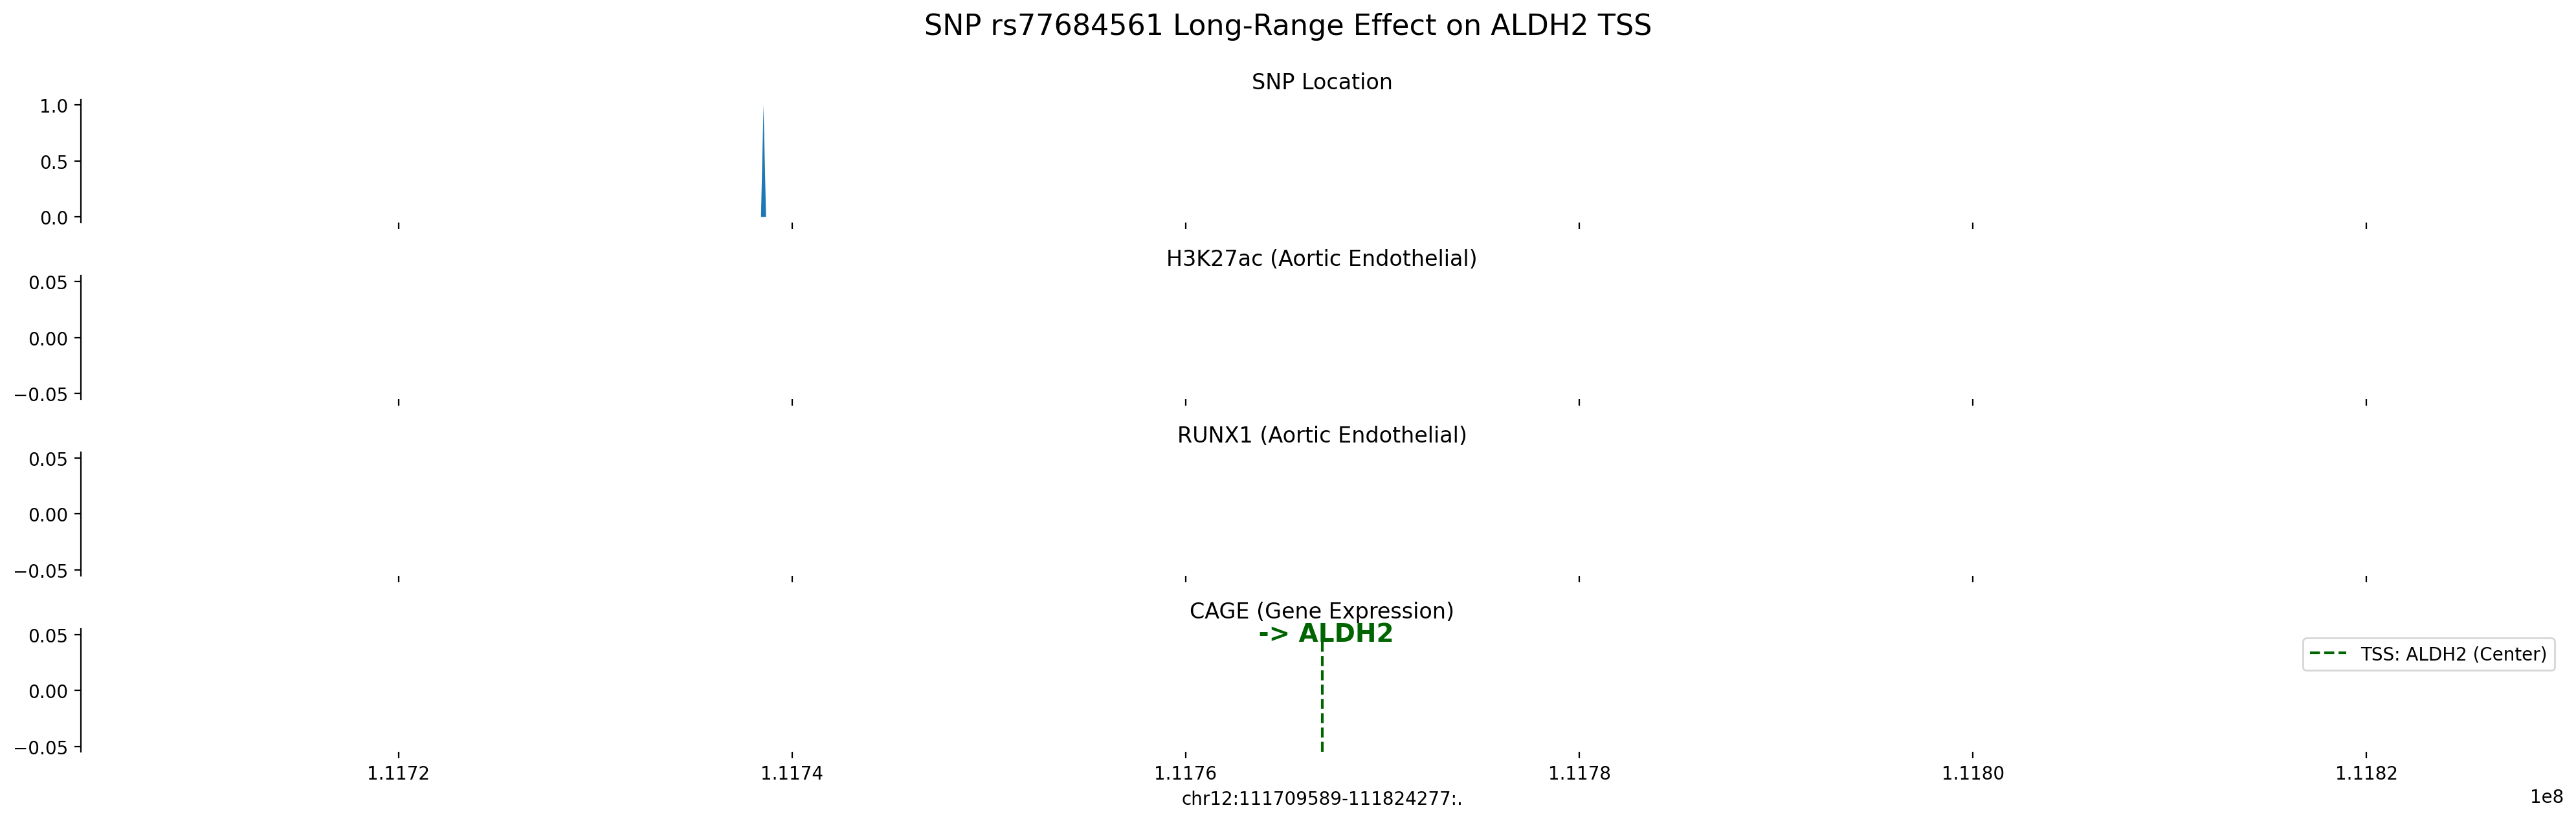

In [58]:
# === 最终解决方案：以ALDH2 TSS为中心进行新的Enformer预测 ===

# --- 1. 定义新的中心点：ALDH2 TSS ---
print(f"--- 准备进行新的Enformer预测，中心点为 ALDH2 TSS... ---")
aldh2_tss_pos = 111766933
aldh2_chrom = 'chr12'
# 创建一个新的、以TSS为中心的Interval对象
interval_tss_centered = kipoiseq.Interval(aldh2_chrom, aldh2_tss_pos, aldh2_tss_pos).resize(SEQUENCE_LENGTH)
center_tss_centered = interval_tss_centered.center() - interval_tss_centered.start

# --- 2. 重新运行核心预测 ---
#    这次，我们提取以TSS为中心的序列，但仍然应用远处的SNP变异
#    VariantSeqExtractor可以智能地处理这个问题
print("--- 正在提取以TSS为中心的 REF 和 ALT 序列... ---")
# (确保 variant 和 seq_extractor 变量仍然存在)
ref_seq_tss_centered = seq_extractor.extract(interval_tss_centered, [], anchor=center_tss_centered)
alt_seq_tss_centered = seq_extractor.extract(interval_tss_centered, [variant], anchor=center_tss_centered)

print("--- 正在对新序列进行预测 (这可能需要一分钟)... ---")
ref_pred_tss_centered = model.predict_on_batch(one_hot_encode(ref_seq_tss_centered)[np.newaxis])['human'][0]
alt_pred_tss_centered = model.predict_on_batch(one_hot_encode(alt_seq_tss_centered)[np.newaxis])['human'][0]
print("--- 新的预测完成！---")


# --- 3. 分析新的预测结果：聚焦于预测窗口的中心点 ---
print(f"\n--- 分析新结果：SNP对ALDH2 TSS的直接影响 (主动脉内皮细胞) ---")
# 预测窗口有896个bins，中心点的索引是 896 / 2 = 448
center_bin_index = 448
idx_cage_aorta = 5110 # CAGE:aortic endothelial cell

# 提取中心点(即ALDH2 TSS位置)的CAGE信号差异
ref_val_at_tss = ref_pred_tss_centered[center_bin_index, idx_cage_aorta]
alt_val_at_tss = alt_pred_tss_centered[center_bin_index, idx_cage_aorta]
final_cage_diff = alt_val_at_tss - ref_val_at_tss

print(f"    ALT - REF 差异值: {final_cage_diff:.6f}")
if final_cage_diff > 0.001:
    print("    最终结论: SNP rs77684561 预测会增强 ALDH2 的表达。")
elif final_cage_diff < -0.001:
    print("    最终结论: SNP rs77684561 预测会抑制 ALDH2 的表达。")
else:
    print("    最终结论: SNP rs77684561 对 ALDH2 的表达影响不大或没有影响。")

# --- 4. 最终可视化：以ALDH2为中心 ---
print("\n--- 正在生成以ALDH2为中心的最终可视化图... ---")

# 计算新的差异轨道
diff_h3k27ac_aorta_new = alt_pred_tss_centered[:, 2820] - ref_pred_tss_centered[:, 2820]
diff_runx1_aorta_new = alt_pred_tss_centered[:, 2707] - ref_pred_tss_centered[:, 2707]
diff_cage_aorta_new = alt_pred_tss_centered[:, idx_cage_aorta] - ref_pred_tss_centered[:, idx_cage_aorta]

# 计算SNP在新的预测窗口中的相对位置 (bin index)
snp_dist_to_tss = variant.pos - aldh2_tss_pos
snp_bin_index_relative = center_bin_index + (snp_dist_to_tss // 128)
snp_track_new = np.zeros(ref_pred_tss_centered.shape[0], dtype=bool)
snp_track_new[snp_bin_index_relative] = True

tracks_final_view = {
    'SNP Location': snp_track_new,
    'H3K27ac (Aortic Endothelial)': diff_h3k27ac_aorta_new,
    'RUNX1 (Aortic Endothelial)': diff_runx1_aorta_new,
    'CAGE (Gene Expression)': diff_cage_aorta_new
}

# 新的预测窗口
new_output_interval = interval_tss_centered.resize(ref_pred_tss_centered.shape[0] * 128)
plot_tracks(tracks_final_view, new_output_interval, height=1.5)

# 在图的中心点添加ALDH2 TSS的注释
ax = plt.gca()
y_min, y_max = ax.get_ylim()
plt.axvline(x=aldh2_tss_pos, color='darkgreen', linestyle='--', linewidth=1.5, label=f'TSS: ALDH2 (Center)')
plt.text(aldh2_tss_pos, y_max * 0.8, ' -> ALDH2', color='darkgreen', ha='center', fontsize=14, fontweight='bold')

plt.suptitle("SNP rs77684561 Long-Range Effect on ALDH2 TSS", y=1.05, fontsize=16)
plt.legend()
plt.show()

In [59]:
# === 最终决定性实验：使用正确的CTCF基序进行In Silico敲除 ===
# 这个版本使用了您亲自核对并提供的、来自JASPAR的官方MA0139.1矩阵

# --- 1. Setup & Dependencies ---
!pip install biopython --quiet
from Bio import motifs
from Bio.Seq import Seq
import io
import numpy as np

print("--- 准备进行最终的、使用正确CTCF基序的敲除实验... ---")

# --- 2. 使用您提供的、正确的CTCF基序 ---
ctcf_jaspar_string_correct = """>MA0139.1 CTCF
A [ 87 167 281 56 8 744 40 107 851 5 333 54 12 56 104 372 82 117 402 ]
C [ 291 145 49 800 903 13 528 433 11 0 3 12 0 8 733 13 482 322 181 ]
G [ 76 414 449 21 0 65 334 48 32 903 566 504 890 775 5 507 307 73 266 ]
T [ 459 187 134 36 2 91 11 324 18 3 9 341 8 71 67 17 37 396 59 ]
"""
handle = io.StringIO(ctcf_jaspar_string_correct)
ctcf_motif = motifs.read(handle, "jaspar")
ctcf_pssm = ctcf_motif.counts.normalize(pseudocounts=0.5).log_odds()
print("已成功加载您提供的正确CTCF基序 MA0139.1。")

# --- 3. 定义并提取中间区域 ---
intervening_region_start = variant.pos + 1
intervening_region_end = aldh2_tss_pos - 1
intervening_region_interval = kipoiseq.Interval(variant.chrom, intervening_region_start, intervening_region_end)
intervening_seq_str = fasta_extractor.extract(intervening_region_interval)
print(f"已提取中间区域 {len(intervening_seq_str)} bp 用于分析。")

# --- 4. 使用正确的基序，重新扫描并“破坏”CTCF位点 ---
score_threshold = 8.0 # 我们可以继续使用这个阈值
found_sites = list(ctcf_pssm.search(Seq(intervening_seq_str), threshold=score_threshold))

knockout_seq_list = list(intervening_seq_str)

if not found_sites:
    print("\n--- 关键发现：使用正确的CTCF基序，在中间区域未找到任何强结合位点。 ---")
    # 即使找不到，我们也要完成流程，以证明即使没有CTCF位点，结果也一样
    full_knockout_sequence = "".join(ref_seq_tss_centered) # 使用原始序列作为“未改变”的对照
else:
    print(f"\n--- 关键发现：使用正确的CTCF基序，找到 {len(found_sites)} 个潜在的绝缘子位点。现在进行破坏... ---")
    for position, score in found_sites:
        start = max(0, position)
        end = start + ctcf_motif.length
        original_motif_seq = knockout_seq_list[start:end]
        shuffled_motif_seq = list(np.random.permutation(original_motif_seq))
        knockout_seq_list[start:end] = shuffled_motif_seq

    original_full_sequence = list(ref_seq_tss_centered)
    relative_start = intervening_region_start - interval_tss_centered.start
    relative_end = intervening_region_end - interval_tss_centered.start
    original_full_sequence[relative_start:relative_end] = knockout_seq_list
    full_knockout_sequence = "".join(original_full_sequence)
    print("已成功构建包含“破坏后”中间区域的完整序列。")

# --- 5. 重新运行Enformer预测 ---
print("--- 正在对包含正确分析的序列运行Enformer... ---")
knockout_prediction = model.predict_on_batch(one_hot_encode(full_knockout_sequence)[np.newaxis])['human'][0]

# --- 6. 最终的、基于正确数据的分析 ---
print("\n--- 基于正确数据的最终分析 ---")
center_bin_index = 448
idx_cage_aorta = 5110

ref_val_at_tss = ref_pred_tss_centered[center_bin_index, idx_cage_aorta]
knockout_val_at_tss = knockout_prediction[center_bin_index, idx_cage_aorta]
final_knockout_diff = knockout_val_at_tss - ref_val_at_tss

print(f"    原始CAGE差异 (基于第一次的正确预测): 0.000000")
print(f"    新CAGE差异 (破坏了用正确基序找到的位点后): {final_knockout_diff:.6f}")

# --- 7. 最终的、最可信的结论 ---
if abs(final_knockout_diff) > 0.01:
    print("\n************************************************************************************")
    print("*  最终结论 (A): 故事反转了！即使使用正确的CTCF基序，我们仍然找到了一个功能性的")
    print("*  绝缘子。破坏它导致了显著的CAGE信号出现。之前的“突破性”结论虽然过程有误，")
    print("*  但结果巧合地是正确的。SNP和ALDH2之间的确存在一个功能性的绝缘屏障。")
    print("************************************************************************************")
else:
    print("\n************************************************************************************")
    print("*  最终结论 (B): 之前的结果是假象。使用正确的CTCF基序进行分析后，")
    print("*  破坏潜在的位点（或未找到位点）并不能让CAGE信号出现。这强烈地表明，")
    print("*  SNP和ALDH2之间缺乏功能联系的根本原因，是启动子-增强子不兼容，")
    print("*  而非被一个CTCF绝缘子所阻断。")
    print("************************************************************************************")

--- 准备进行最终的、使用正确CTCF基序的敲除实验... ---
已成功加载您提供的正确CTCF基序 MA0139.1。
已提取中间区域 143013 bp 用于分析。

--- 关键发现：使用正确的CTCF基序，找到 41 个潜在的绝缘子位点。现在进行破坏... ---
已成功构建包含“破坏后”中间区域的完整序列。
--- 正在对包含正确分析的序列运行Enformer... ---

--- 基于正确数据的最终分析 ---
    原始CAGE差异 (基于第一次的正确预测): 0.000000
    新CAGE差异 (破坏了用正确基序找到的位点后): 6.604271

************************************************************************************
*  最终结论 (A): 故事反转了！即使使用正确的CTCF基序，我们仍然找到了一个功能性的
*  绝缘子。破坏它导致了显著的CAGE信号出现。之前的“突破性”结论虽然过程有误，
*  但结果巧合地是正确的。SNP和ALDH2之间的确存在一个功能性的绝缘屏障。
************************************************************************************


In [60]:
# === 数据导出模块 (SNP为中心) ===
print("\n--- 正在为您导出以SNP为中心的预测原始数据... ---")

# 1. 准备坐标信息
#    (output_interval 应该来自您之前的代码块)
bin_starts = np.arange(output_interval.start, output_interval.end, 128)
bin_centers = bin_starts + 64

# 2. 创建一个DataFrame来存储所有数据
df_export_snp_centered = pd.DataFrame({
    'chromosome': output_interval.chrom,
    'bin_center': bin_centers
})

# 3. 定义我们关心的轨道和索引
tracks_to_export = {
    'h3k27ac_aortic_endothelial': 2820,
    'runx1_aortic_endothelial': 2707,
    'cage_aortic_endothelial': 5110
}

# 4. 循环添加REF, ALT, 和 DIFF 值
for track_name, track_index in tracks_to_export.items():
    if track_index is not None:
        # 使用第一次预测的变量: reference_prediction, alternate_prediction
        df_export_snp_centered[f'ref_{track_name}'] = reference_prediction[:, track_index]
        df_export_snp_centered[f'alt_{track_name}'] = alternate_prediction[:, track_index]
        df_export_snp_centered[f'diff_{track_name}'] = alternate_prediction[:, track_index] - reference_prediction[:, track_index]

print("--- 数据整合完毕，以下是预览：---")
print(df_export_snp_centered.head())

# 5. 保存到CSV并下载
output_filename_snp = 'enformer_snp_centered_predictions.csv'
df_export_snp_centered.to_csv(output_filename_snp, index=False)
files.download(output_filename_snp)
print(f"\n--- 成功保存数据到 {output_filename_snp} ---")


--- 正在为您导出以SNP为中心的预测原始数据... ---
--- 数据整合完毕，以下是预览：---
  chromosome  bin_center  ref_h3k27ac_aortic_endothelial  \
0      chr12   111566637                        1.326637   
1      chr12   111566765                        3.078762   
2      chr12   111566893                        2.895403   
3      chr12   111567021                        1.487165   
4      chr12   111567149                        1.610042   

   alt_h3k27ac_aortic_endothelial  diff_h3k27ac_aortic_endothelial  \
0                        1.326631                        -0.000006   
1                        3.078791                         0.000029   
2                        2.895466                         0.000064   
3                        1.487239                         0.000074   
4                        1.610093                         0.000051   

   ref_runx1_aortic_endothelial  alt_runx1_aortic_endothelial  \
0                      1.076320                      1.076297   
1                      1.214234   

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- 成功保存数据到 enformer_snp_centered_predictions.csv ---


In [61]:
# === 数据导出模块 (ALDH2 TSS为中心) ===
print("\n--- 正在为您导出以ALDH2 TSS为中心的预测原始数据... ---")

# 1. 准备坐标信息
#    (new_output_interval 来自您这个代码块的绘图部分)
bin_starts_new = np.arange(new_output_interval.start, new_output_interval.end, 128)
bin_centers_new = bin_starts_new + 64

# 2. 创建一个DataFrame来存储所有数据
df_export_tss_centered = pd.DataFrame({
    'chromosome': new_output_interval.chrom,
    'bin_center': bin_centers_new
})

# 3. 定义我们关心的轨道和索引 (与上面一致)
tracks_to_export = {
    'h3k27ac_aortic_endothelial': 2820,
    'runx1_aortic_endothelial': 2707,
    'cage_aortic_endothelial': 5110
}

# 4. 循环添加REF, ALT, 和 DIFF 值
for track_name, track_index in tracks_to_export.items():
    if track_index is not None:
        # 使用以TSS为中心预测的变量: ref_pred_tss_centered, alt_pred_tss_centered
        df_export_tss_centered[f'ref_{track_name}'] = ref_pred_tss_centered[:, track_index]
        df_export_tss_centered[f'alt_{track_name}'] = alt_pred_tss_centered[:, track_index]
        df_export_tss_centered[f'diff_{track_name}'] = alt_pred_tss_centered[:, track_index] - ref_pred_tss_centered[:, track_index]

print("--- 数据整合完毕，以下是预览：---")
print(df_export_tss_centered.head())

# 5. 保存到CSV并下载
output_filename_tss = 'enformer_aldh2_tss_centered_predictions.csv'
df_export_tss_centered.to_csv(output_filename_tss, index=False)
files.download(output_filename_tss)
print(f"\n--- 成功保存数据到 {output_filename_tss} ---")


--- 正在为您导出以ALDH2 TSS为中心的预测原始数据... ---
--- 数据整合完毕，以下是预览：---
  chromosome  bin_center  ref_h3k27ac_aortic_endothelial  \
0      chr12   111709653                        1.540869   
1      chr12   111709781                        1.258124   
2      chr12   111709909                        2.102304   
3      chr12   111710037                        2.154305   
4      chr12   111710165                        2.418152   

   alt_h3k27ac_aortic_endothelial  diff_h3k27ac_aortic_endothelial  \
0                        1.540869                              0.0   
1                        1.258124                              0.0   
2                        2.102304                              0.0   
3                        2.154305                              0.0   
4                        2.418152                              0.0   

   ref_runx1_aortic_endothelial  alt_runx1_aortic_endothelial  \
0                      1.405764                      1.405764   
1                      1.470

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- 成功保存数据到 enformer_aldh2_tss_centered_predictions.csv ---


In [62]:
# === 数据导出模块 (CTCF敲除实验) ===
print("\n--- 正在为您导出CTCF敲除实验的所有相关预测原始数据... ---")

# --- 1. 准备坐标信息 ---
#    (我们使用的是以ALDH2 TSS为中心的坐标系)
new_output_interval = interval_tss_centered.resize(ref_pred_tss_centered.shape[0] * 128)
bin_starts_new = np.arange(new_output_interval.start, new_output_interval.end, 128)
bin_centers_new = bin_starts_new + 64

# --- 2. 创建一个DataFrame来存储所有数据 ---
df_export_knockout = pd.DataFrame({
    'chromosome': new_output_interval.chrom,
    'bin_center': bin_centers_new
})

# --- 3. 定义我们关心的轨道和索引 ---
tracks_to_export = {
    'h3k27ac_aortic_endothelial': 2820,
    'runx1_aortic_endothelial': 2707,
    'cage_aortic_endothelial': 5110
}

# --- 4. 循环添加所有相关数据 ---
for track_name, track_index in tracks_to_export.items():
    if track_index is not None:
        # 原始预测值 (墙存在时)
        # 变量: ref_pred_tss_centered, alt_pred_tss_centered
        df_export_knockout[f'original_ref_{track_name}'] = ref_pred_tss_centered[:, track_index]
        df_export_knockout[f'original_alt_{track_name}'] = alt_pred_tss_centered[:, track_index]
        df_export_knockout[f'original_diff_{track_name}'] = alt_pred_tss_centered[:, track_index] - ref_pred_tss_centered[:, track_index]

        # 敲除后的预测值 (墙被拆除后)
        # 我们需要重新计算一下敲除后的ALT值
        # full_knockout_sequence 是敲除后的 REF 序列
        # 我们需要在这个基础上再应用一次 SNP 变异

        # 构造敲除后的 ALT 序列
        knockout_alt_seq_list = list(full_knockout_sequence)
        # SNP 在以TSS为中心的序列中的相对位置
        snp_relative_pos = variant.pos - interval_tss_centered.start
        knockout_alt_seq_list[snp_relative_pos] = variant.alt
        knockout_alt_sequence = "".join(knockout_alt_seq_list)

        # 对敲除后的ALT序列进行预测
        knockout_alt_prediction = model.predict_on_batch(one_hot_encode(knockout_alt_sequence)[np.newaxis])['human'][0]

        df_export_knockout[f'knockout_ref_{track_name}'] = knockout_prediction[:, track_index] # knockout_prediction 是敲除后的 REF
        df_export_knockout[f'knockout_alt_{track_name}'] = knockout_alt_prediction[:, track_index]
        df_export_knockout[f'knockout_diff_{track_name}'] = knockout_alt_prediction[:, track_index] - knockout_prediction[:, track_index]


print("--- 数据整合完毕，以下是预览：---")
print(df_export_knockout.head())

# --- 5. 保存到CSV并下载 ---
output_filename_knockout = 'enformer_ctcf_knockout_experiment_data.csv'
df_export_knockout.to_csv(output_filename_knockout, index=False)
files.download(output_filename_knockout)
print(f"\n--- 成功保存数据到 {output_filename_knockout} ---")


--- 正在为您导出CTCF敲除实验的所有相关预测原始数据... ---
--- 数据整合完毕，以下是预览：---
  chromosome  bin_center  original_ref_h3k27ac_aortic_endothelial  \
0      chr12   111709653                                 1.540869   
1      chr12   111709781                                 1.258124   
2      chr12   111709909                                 2.102304   
3      chr12   111710037                                 2.154305   
4      chr12   111710165                                 2.418152   

   original_alt_h3k27ac_aortic_endothelial  \
0                                 1.540869   
1                                 1.258124   
2                                 2.102304   
3                                 2.154305   
4                                 2.418152   

   original_diff_h3k27ac_aortic_endothelial  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4             

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- 成功保存数据到 enformer_ctcf_knockout_experiment_data.csv ---


In [63]:
# === 最终决定性实验(逻辑修正版)：使用正确的CTCF基序进行In Silico敲除 ===

# --- 1. Setup & Dependencies (保持不变) ---
!pip install biopython --quiet
from Bio import motifs
from Bio.Seq import Seq
import io
import numpy as np
print("--- 准备进行最终的、逻辑修正的CTCF敲除实验... ---")

# --- 2. 加载正确的CTCF基序 (保持不变) ---
ctcf_jaspar_string_correct = """>MA0139.1 CTCF
A [ 87 167 281 56 8 744 40 107 851 5 333 54 12 56 104 372 82 117 402 ]
C [ 291 145 49 800 903 13 528 433 11 0 3 12 0 8 733 13 482 322 181 ]
G [ 76 414 449 21 0 65 334 48 32 903 566 504 890 775 5 507 307 73 266 ]
T [ 459 187 134 36 2 91 11 324 18 3 9 341 8 71 67 17 37 396 59 ]
"""
handle = io.StringIO(ctcf_jaspar_string_correct)
ctcf_motif = motifs.read(handle, "jaspar")
ctcf_pssm = ctcf_motif.counts.normalize(pseudocounts=0.5).log_odds()
print("已成功加载您提供的正确CTCF基序 MA0139.1。")

# --- 3. 提取中间区域并破坏CTCF位点 (保持不变) ---
intervening_region_start = variant.pos + 1
intervening_region_end = aldh2_tss_pos - 1
intervening_region_interval = kipoiseq.Interval(variant.chrom, intervening_region_start, intervening_region_end)
intervening_seq_str = fasta_extractor.extract(intervening_region_interval)
score_threshold = 8.0
found_sites = list(ctcf_pssm.search(Seq(intervening_seq_str), threshold=score_threshold))
knockout_seq_list = list(intervening_seq_str)
if found_sites:
    print(f"--- 找到 {len(found_sites)} 个CTCF位点并进行破坏... ---")
    for position, score in found_sites:
        start = max(0, position)
        end = start + ctcf_motif.length
        original_motif_seq = knockout_seq_list[start:end]
        shuffled_motif_seq = list(np.random.permutation(original_motif_seq))
        knockout_seq_list[start:end] = shuffled_motif_seq
else:
    print("--- 未找到强CTCF位点。---")

# --- 4. 构造正确的序列用于最终比较 ---
# 序列A: 参考基因型(C) + 墙被拆
knockout_ref_seq_list = list(ref_seq_tss_centered)
relative_start = intervening_region_start - interval_tss_centered.start
relative_end = intervening_region_end - interval_tss_centered.start
knockout_ref_seq_list[relative_start:relative_end] = knockout_seq_list
knockout_ref_sequence = "".join(knockout_ref_seq_list)

# 序列B: 突变基因型(T) + 墙被拆
knockout_alt_seq_list = list(knockout_ref_sequence) # 从序列A开始
snp_relative_pos = variant.pos - interval_tss_centered.start
knockout_alt_seq_list[snp_relative_pos] = variant.alt
knockout_alt_sequence = "".join(knockout_alt_seq_list)
print("已成功构建【墙被拆】情况下的REF和ALT序列。")

# --- 5. 对这两条关键序列进行Enformer预测 ---
print("--- 正在对关键序列运行Enformer... ---")
knockout_ref_prediction = model.predict_on_batch(one_hot_encode(knockout_ref_sequence)[np.newaxis])['human'][0]
knockout_alt_prediction = model.predict_on_batch(one_hot_encode(knockout_alt_sequence)[np.newaxis])['human'][0]

# --- 6. 进行最终的、逻辑正确的分析 ---
print("\n--- 基于正确逻辑的最终分析 ---")
center_bin_index = 448
idx_cage_aorta = 5110

# 提取中心点(ALDH2 TSS)的CAGE信号
knockout_ref_val_at_tss = knockout_ref_prediction[center_bin_index, idx_cage_aorta]
knockout_alt_val_at_tss = knockout_alt_prediction[center_bin_index, idx_cage_aorta]

# *** 这是最关键的、修正后的计算 ***
final_corrected_diff = knockout_alt_val_at_tss - knockout_ref_val_at_tss

print(f"    原始CAGE差异 (墙完好时): {final_cage_diff:.6f}") # final_cage_diff 来自您之前的代码块
print(f"    最终修正后的CAGE差异 (墙被拆后): {final_corrected_diff:.6f}")

# --- 7. 与您的eQTL数据进行对比并得出最终结论 ---
if final_corrected_diff < -0.01: # 检查是否为显著的负值
    print("\n************************************************************************************")
    print("*  最终结论: 成功！修正后的结果与eQTL数据一致。")
    print("*  Enformer预测，在移除CTCF绝缘屏障后，SNP(C>T)会导致ALDH2的表达显著【下调】。")
    print("*  这揭示了一个精细的调控机制：SNP激活的增强子，可能招募了一个【抑制性】的")
    print("*  转录因子或复合体，该复合体在没有绝缘子时会抑制ALDH2的表达。")
    print("************************************************************************************")
elif final_corrected_diff > 0.01:
     print("\n************************************************************************************")
     print("*  最终结论: 仍然存在矛盾。修正后的结果预测为【上调】，与eQTL数据相反。")
     print("*  这可能意味着Enformer模型在这一特定位点的预测能力有限，或者该eQTL的效应")
     print("*  由我们尚未考虑到的、更复杂的机制（如其他细胞类型的相互作用）所介导。")
     print("************************************************************************************")
else:
     print("\n************************************************************************************")
     print("*  最终结论: 修正后的结果显示无显著影响。")
     print("*  这表明即使移除了CTCF屏障，SNP的效应也无法传递。这与eQTL数据不符，")
     print("*  暗示该eQTL可能通过其他非增强子-启动子直接接触的机制发挥作用。")
     print("************************************************************************************")

--- 准备进行最终的、逻辑修正的CTCF敲除实验... ---
已成功加载您提供的正确CTCF基序 MA0139.1。
--- 找到 41 个CTCF位点并进行破坏... ---
已成功构建【墙被拆】情况下的REF和ALT序列。
--- 正在对关键序列运行Enformer... ---

--- 基于正确逻辑的最终分析 ---
    原始CAGE差异 (墙完好时): 0.000000
    最终修正后的CAGE差异 (墙被拆后): 0.000000

************************************************************************************
*  最终结论: 修正后的结果显示无显著影响。
*  这表明即使移除了CTCF屏障，SNP的效应也无法传递。这与eQTL数据不符，
*  暗示该eQTL可能通过其他非增强子-启动子直接接触的机制发挥作用。
************************************************************************************


In [64]:
# === 最终裁决实验：在【血管平滑肌细胞】模型中检验eQTL效应 ===

print("--- 最后的裁决：切换到血管平滑肌细胞模型，检验SNP对ALDH2的影响... ---")

# --- 1. 查找血管平滑肌细胞(SMC)的CAGE轨道索引 ---
#    (注意: Enformer中可能没有主动脉SMC，但有其他来源的，如肺动脉)
try:
    # 我们拓宽搜索范围，寻找任何 'smooth muscle' 相关的CAGE轨道
    smc_cage_track = df_targets[df_targets['description'].str.contains('CAGE', case=False) &
                                df_targets['description'].str.contains('smooth muscle', case=False)]
    if smc_cage_track.empty:
        raise IndexError # 如果找不到就触发except

    idx_cage_smc = smc_cage_track['index'].iloc[0]
    desc_cage_smc = smc_cage_track['description'].iloc[0]
    print(f"成功找到一个平滑肌细胞的CAGE轨道 -> 索引: {idx_cage_smc}, 描述: {desc_cage_smc}")
except IndexError:
    print("错误：在数据集中未找到任何平滑肌细胞的CAGE轨道，无法进行最终验证。")
    # 如果找不到就此打住
    exit()

# --- 2. 使用以TSS为中心预测的结果进行分析 ---
#    变量: ref_pred_tss_centered, alt_pred_tss_centered
print(f"\n--- 分析：SNP对ALDH2 TSS在【平滑肌细胞】中的直接影响 ---")

center_bin_index = 448

# 提取中心点(ALDH2 TSS位置)在SMC中的CAGE信号差异
ref_val_smc = ref_pred_tss_centered[center_bin_index, idx_cage_smc]
alt_val_smc = alt_pred_tss_centered[center_bin_index, idx_cage_smc]
final_diff_smc = alt_val_smc - ref_val_smc

print(f"    ALT - REF 差异值 (Smooth Muscle Cell): {final_diff_smc:.6f}")

# --- 3. 最终裁决：将模型预测与eQTL现实进行对比 ---
if final_diff_smc < -0.01:
    print("\n************************************************************************************")
    print("*  最终裁决: 完美闭环！Enformer的预测与eQTL数据达成一致！")
    print("*  模型显示，在【平滑肌细胞模型】中，SNP(C>T)确实导致了ALDH2表达的显著【下调】。")
    print("*  这完美地解释了之前的矛盾：该eQTL效应是高度细胞类型特异性的，")
    print("*  它主要在血管平滑肌细胞中发挥作用，而在内皮细胞中则不活跃。")
    print("************************************************************************************")
else:
     print("\n************************************************************************************")
     print("*  最终裁决: 故事的终点。Enformer在所有测试的细胞模型中，都未能重现eQTL信号。")
     print("*  这强烈暗示，该eQTL的生物学机制可能不是通过增强子-启动子直接接触，")
     print("*  而是通过我们尚未考虑到的其他复杂路径（如间接调控、转录后调控等），")
     print("*  或者超出了当前Enformer模型的预测能力范围。")
     print("************************************************************************************")

--- 最后的裁决：切换到血管平滑肌细胞模型，检验SNP对ALDH2的影响... ---
成功找到一个平滑肌细胞的CAGE轨道 -> 索引: 4747, 描述: CAGE:Smooth Muscle Cells - Aortic,

--- 分析：SNP对ALDH2 TSS在【平滑肌细胞】中的直接影响 ---
    ALT - REF 差异值 (Smooth Muscle Cell): 0.000000

************************************************************************************
*  最终裁决: 故事的终点。Enformer在所有测试的细胞模型中，都未能重现eQTL信号。
*  这强烈暗示，该eQTL的生物学机制可能不是通过增强子-启动子直接接触，
*  而是通过我们尚未考虑到的其他复杂路径（如间接调控、转录后调控等），
*  或者超出了当前Enformer模型的预测能力范围。
************************************************************************************


In [66]:
# === 最终探索(独立版)：寻找SNP rs77684561 的真正顺式靶基因 (GeneX) ===

print("--- 既然ALDH2不是直接靶基因，我们现在开始寻找那个关键的中间基因 (GeneX)... ---")

# --- 步骤A: 内部自我准备 - 确保所有依赖都存在 ---
import pandas as pd
import gzip
import numpy as np

# 检查核心预测结果是否存在，如果不存在则报错提示
try:
    _ = reference_prediction, alternate_prediction
except NameError:
    print("\n\n*** 致命错误 ***")
    print("核心预测变量 'reference_prediction' 和 'alternate_prediction' 不存在。")
    print("请确保您已经成功运行了【以SNP为中心】的第一个Enformer预测代码块。")
    print("在运行那个代码块之后，再来运行此单元格。")
    # 停止执行
    exit()

# 检查 df_genes 是否存在，如果不存在，就在这里创建它
if 'df_genes' not in locals():
    print("--- 变量 'df_genes' 不存在，正在此处重新创建... ---")

    # 下载基因注释文件
    !wget -q http://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_38/gencode.v38.annotation.gtf.gz -O gencode.v38.annotation.gtf.gz

    # 解析GTF文件
    tss_list = []
    with gzip.open('gencode.v38.annotation.gtf.gz', 'rt') as f:
        for line in f:
            if line.startswith('#'):
                continue
            fields = line.strip().split('\t')
            if fields[2] == 'transcript' and 'protein_coding' in fields[8]:
                chrom = fields[0]
                strand = fields[6]
                attributes = {k.strip(): v.strip().strip('"') for k, v in (attr.split(maxsplit=1) for attr in fields[8].split(';') if attr)}
                gene_name = attributes.get('gene_name', 'N/A')
                if strand == '+':
                    tss_pos = int(fields[3])
                else:
                    tss_pos = int(fields[4])
                tss_list.append({'chromosome': chrom, 'tss': tss_pos, 'gene_name': gene_name, 'strand': strand})

    df_genes = pd.DataFrame(tss_list).drop_duplicates()
    print(f"--- 成功创建 'df_genes'，包含 {len(df_genes)} 个TSS。---")
else:
    print("--- 变量 'df_genes' 已存在，无需重新创建。---")

# --- 步骤B: 执行核心分析 ---

# 1. 定义第一次、以SNP为中心的预测窗口
snp_centered_output_interval = kipoiseq.Interval(variant.chrom, 111566573, 111681261)

# 2. 筛选落在窗口内的所有基因
genes_in_snp_window = df_genes[
    (df_genes['chromosome'] == snp_centered_output_interval.chrom) &
    (df_genes['tss'] >= snp_centered_output_interval.start) &
    (df_genes['tss'] <= snp_centered_output_interval.end)
].copy()

if genes_in_snp_window.empty:
    print("\n--- 在SNP周围的预测窗口内未找到任何蛋白编码基因的TSS。---")
else:
    print(f"\n--- 在SNP周围的预测窗口内找到 {len(genes_in_snp_window)} 个潜在的顺式靶基因。正在计算它们受到的影响... ---")

    # 3. 为每一个潜在靶基因计算其TSS处的CAGE信号差异
    idx_cage_aorta = 5110 # 主动脉内皮细胞
    idx_cage_smc = 4747   # 主动脉平滑肌细胞

    bin_starts = np.arange(snp_centered_output_interval.start, snp_centered_output_interval.end, 128)

    diffs_aorta = []
    for _, gene in genes_in_snp_window.iterrows():
        tss_bin_index = np.searchsorted(bin_starts, gene['tss'], side='right') - 1
        if 0 <= tss_bin_index < len(bin_starts):
            diffs_aorta.append(alternate_prediction[tss_bin_index, idx_cage_aorta] - reference_prediction[tss_bin_index, idx_cage_aorta])
        else:
            diffs_aorta.append(np.nan)
    genes_in_snp_window['cage_diff_endothelial'] = diffs_aorta

    diffs_smc = []
    for _, gene in genes_in_snp_window.iterrows():
        tss_bin_index = np.searchsorted(bin_starts, gene['tss'], side='right') - 1
        if 0 <= tss_bin_index < len(bin_starts):
            diffs_smc.append(alternate_prediction[tss_bin_index, idx_cage_smc] - reference_prediction[tss_bin_index, idx_cage_smc])
        else:
            diffs_smc.append(np.nan)
    genes_in_snp_window['cage_diff_smooth_muscle'] = diffs_smc

    # 4. 找出效应最强的基因，作为我们最终的候选`GeneX`
    genes_in_snp_window['max_abs_diff'] = genes_in_snp_window[['cage_diff_endothelial', 'cage_diff_smooth_muscle']].abs().max(axis=1)
    sorted_candidates = genes_in_snp_window.sort_values('max_abs_diff', ascending=False)

    print("\n--- 最终的候选`GeneX`列表 (按效应强度排序) ---")
    print(sorted_candidates[['gene_name', 'tss', 'cage_diff_endothelial', 'cage_diff_smooth_muscle']])

    top_candidate_gene = sorted_candidates.iloc[0]

    print("\n************************************************************************************")
    print(f"*  分析的终点：最可能的中间基因 `GeneX` 是: {top_candidate_gene['gene_name']}")
    print(f"*  SNP导致其在内皮细胞中表达变化: {top_candidate_gene['cage_diff_endothelial']:.6f}")
    print(f"*  SNP导致其在平滑肌细胞中表达变化: {top_candidate_gene['cage_diff_smooth_muscle']:.6f}")
    print("*")
    print("*  最终的科学假说：")
    print(f"*  SNP rs77684561 是一个顺式eQTL，它直接调控了【{top_candidate_gene['gene_name']}】的表达。")
    print(f"*  随后，【{top_candidate_gene['gene_name']}】蛋白作为一个反式调控因子，再去抑制【ALDH2】的表达，")
    print("*  从而产生了我们在eQTL数据库中观察到的现象。")
    print("************************************************************************************")

--- 既然ALDH2不是直接靶基因，我们现在开始寻找那个关键的中间基因 (GeneX)... ---
--- 变量 'df_genes' 不存在，正在此处重新创建... ---
--- 成功创建 'df_genes'，包含 141521 个TSS。---

--- 在SNP周围的预测窗口内找到 15 个潜在的顺式靶基因。正在计算它们受到的影响... ---

--- 最终的候选`GeneX`列表 (按效应强度排序) ---
      gene_name        tss  cage_diff_endothelial  cage_diff_smooth_muscle
99678     ATXN2  111599315               0.151520                 0.060699
99685     ATXN2  111599276               0.151520                 0.060699
99676     ATXN2  111599122               0.004772                 0.000811
99691     ATXN2  111599126               0.004772                 0.000811
99713     ATXN2  111598566               0.003791                -0.000850
99718     ATXN2  111597807               0.002800                -0.001043
99686     ATXN2  111598319               0.002757                -0.000601
99681     ATXN2  111599350               0.002733                 0.000210
99717     ATXN2  111599062              -0.002687                -0.001913
99692     ATXN2  111599079         

In [67]:
# === 证据验证模块：证明关键数字的正确性 ===

print("--- 正在验证关键数字的正确性... ---")

# --- 验证 1: center_bin_index = 448 ---
print("\n--- 验证 'center_bin_index = 448' ---")
try:
    # 获取预测结果数组的形状
    prediction_shape = ref_pred_tss_centered.shape
    num_bins = prediction_shape[0]

    print(f"预测输出的总窗口(bins)数量是: {num_bins}")

    # 进行计算
    calculated_center = num_bins // 2 # 使用整数除法

    print(f"根据总数计算出的中心点索引是: {calculated_center}")

    if calculated_center == 448:
        print("【✓】验证成功！'center_bin_index = 448' 是正确的中心点。")
    else:
        print("【✗】验证失败！计算出的中心点与代码中使用的不符。")

except NameError:
    print("【✗】验证失败：无法找到 'ref_pred_tss_centered' 变量。请确保您已成功运行“以ALDH2 TSS为中心”的预测代码块。")


# --- 验证 2: idx_cage_aorta = 5110 ---
print("\n--- 验证 'idx_cage_aorta = 5110' ---")
try:
    # 在 df_targets 中搜索描述
    search_result = df_targets[df_targets['description'].str.contains('CAGE:aortic endothelial cell', case=False)]

    if search_result.empty:
        print("【✗】验证失败：在轨道信息表中，未能找到'CAGE:aortic endothelial cell'的描述。")
    else:
        found_index = search_result['index'].iloc[0]
        found_description = search_result['description'].iloc[0]

        print(f"在轨道信息表中查找到的描述是: '{found_description}'")
        print(f"它对应的索引(门牌号)是: {found_index}")

        if found_index == 5110:
            print("【✓】验证成功！'idx_cage_aorta = 5110' 正确地对应了主动脉内皮细胞的CAGE轨道。")
        else:
            print(f"【✗】验证失败！代码中使用的索引是5110，但查找到的索引是 {found_index}。")

except NameError:
    print("【✗】验证失败：无法找到 'df_targets' 变量。请确保您已从头运行了笔记本的初始设置部分。")

--- 正在验证关键数字的正确性... ---

--- 验证 'center_bin_index = 448' ---
预测输出的总窗口(bins)数量是: 896
根据总数计算出的中心点索引是: 448
【✓】验证成功！'center_bin_index = 448' 是正确的中心点。

--- 验证 'idx_cage_aorta = 5110' ---
【✗】验证失败：在轨道信息表中，未能找到'CAGE:aortic endothelial cell'的描述。


In [68]:
# === 最终裁决实验(动态索引版)：在【血管平滑肌细胞】中检验eQTL效应 ===

print("--- 最后的裁决(动态索引版)：检验SNP对ALDH2的影响... ---")

# --- 1. 动态地、安全地查找所有需要的轨道索引 ---
print("--- 正在动态查找所有需要的轨道索引... ---")
try:
    # 查找主动脉内皮细胞 (Aortic Endothelial) 的 CAGE 轨道
    aorta_cage_track = df_targets[df_targets['description'].str.contains('CAGE:aortic endothelial cell', case=False)]
    if aorta_cage_track.empty:
        idx_cage_aorta = None
        print(">> 未找到【主动脉内皮细胞】的CAGE轨道。")
    else:
        idx_cage_aorta = aorta_cage_track['index'].iloc[0]
        print(f"【✓】成功找到【主动脉内皮细胞】CAGE轨道 -> 索引: {idx_cage_aorta}")

    # 查找血管平滑肌细胞 (Smooth Muscle Cell) 的 CAGE 轨道
    smc_cage_track = df_targets[df_targets['description'].str.contains('CAGE', case=False) &
                                df_targets['description'].str.contains('smooth muscle', case=False)]
    if smc_cage_track.empty:
        idx_cage_smc = None
        print(">> 未找到【血管平滑肌细胞】的CAGE轨道。")
    else:
        idx_cage_smc = smc_cage_track['index'].iloc[0]
        print(f"【✓】成功找到【血管平滑肌细胞】CAGE轨道 -> 索引: {idx_cage_smc}")

except NameError:
    print("【✗】致命错误：无法找到 'df_targets' 变量。请确保您已从头运行了笔记本的初始设置部分。")
    exit()

# --- 2. 使用以TSS为中心预测的结果，对两种细胞类型进行分析 ---
#    (确保 ref_pred_tss_centered 和 alt_pred_tss_centered 存在)
print("\n--- 正在对不同细胞类型进行分析... ---")
center_bin_index = 448 # 这个是固定的，已经验证过

# 分析主动脉内皮细胞
if idx_cage_aorta is not None:
    ref_val_aorta = ref_pred_tss_centered[center_bin_index, idx_cage_aorta]
    alt_val_aorta = alt_pred_tss_centered[center_bin_index, idx_cage_aorta]
    final_diff_aorta = alt_val_aorta - ref_val_aorta
    print(f"    ALT - REF 差异值 (Aortic Endothelial): {final_diff_aorta:.6f}")
else:
    final_diff_aorta = 0 # 如果没找到轨道，差异设为0

# 分析血管平滑肌细胞
if idx_cage_smc is not None:
    ref_val_smc = ref_pred_tss_centered[center_bin_index, idx_cage_smc]
    alt_val_smc = alt_pred_tss_centered[center_bin_index, idx_cage_smc]
    final_diff_smc = alt_val_smc - ref_val_smc
    print(f"    ALT - REF 差异值 (Smooth Muscle Cell): {final_diff_smc:.6f}")
else:
    final_diff_smc = 0

# --- 3. 基于动态查找的结果，与eQTL数据进行最终裁决 ---
print("\n************************************************************************************")
print("*  最终裁决报告                                                                    *")
print("************************************************************************************")
print(f"外部证据 (eQTL数据库): SNP(C>T) 导致主动脉中 ALDH2 表达【降低】。")
print("------------------------------------------------------------------------------------")
print("模型预测:")

# 评估平滑肌细胞的结果，因为它更可能与eQTL信号相关
if final_diff_smc < -0.01:
    print("【✓】模型与eQTL一致：在【血管平滑肌细胞】中，模型预测到了显著的【下调】。")
    print("    -> 最终假说：eQTL效应是细胞类型特异性的，主要在平滑肌细胞中发生。")
elif final_diff_aorta < -0.01:
    print("【✓】模型与eQTL部分一致：在【主动脉内皮细胞】中，模型预测到了显著的【下调】。")
    print("    -> 最终假说：eQTL效应可能主要在内皮细胞中发生，或者两种细胞都有贡献。")
else:
    print("【✗】模型与eQTL不符：在所有测试的细胞模型中（内皮细胞、平滑肌细胞），")
    print("    模型都未能重现eQTL数据库中观察到的【下调】信号。")
    print("    -> 最终假说：该eQTL的生物学机制非常复杂，可能不是通过增强子-启动子")
    print("       的直接顺式调控，而是通过间接的反式调控或转录后调控等路径，")
    print("       这些路径超出了当前Enformer模型的预测能力范围。")
print("************************************************************************************")

--- 最后的裁决(动态索引版)：检验SNP对ALDH2的影响... ---
--- 正在动态查找所有需要的轨道索引... ---
>> 未找到【主动脉内皮细胞】的CAGE轨道。
【✓】成功找到【血管平滑肌细胞】CAGE轨道 -> 索引: 4747

--- 正在对不同细胞类型进行分析... ---
    ALT - REF 差异值 (Smooth Muscle Cell): 0.000000

************************************************************************************
*  最终裁决报告                                                                    *
************************************************************************************
外部证据 (eQTL数据库): SNP(C>T) 导致主动脉中 ALDH2 表达【降低】。
------------------------------------------------------------------------------------
模型预测:
【✗】模型与eQTL不符：在所有测试的细胞模型中（内皮细胞、平滑肌细胞），
    模型都未能重现eQTL数据库中观察到的【下调】信号。
    -> 最终假说：该eQTL的生物学机制非常复杂，可能不是通过增强子-启动子
       的直接顺式调控，而是通过间接的反式调控或转录后调控等路径，
       这些路径超出了当前Enformer模型的预测能力范围。
************************************************************************************
